In [ ]:
%%HTML
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>

In [1]:
import PySimpleGUI as sg
from pykat import finesse
from pykat.commands import *
import pykat
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import sys
import math
import datetime
import mifsim_gui_function as mifsim

# LightGrey2ボタンの背景が見えない
# チェックボックスが見えないからどのテーマでも個別に設定するべき
sg.theme('LightGrey2')

def collapse(layout, key):
    """
    Helper function that creates a Column that can be later made hidden, thus appearing "collapsed"
    :param layout: The layout for the section
    :param key: Key used to make this seciton visible / invisible
    :return: A pinned column that can be placed directly into your layout
    :rtype: sg.pin
    """
    return sg.pin(sg.Column(layout, key=key))

..-
    PyKat 1.2.1           _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



In [2]:
# 全部の種類をまとめたものをmifsim_gui_function.pyから持ってくる
all_ports = mifsim.all_ports
all_important_ports = mifsim.all_important_ports
all_gui_section_keys = mifsim.all_gui_section_keys
all_radiobox_keys = mifsim.all_radiobox_keys

pd0


### FPMI

const fsb1 16.881M
const fsb2 45.0159M

# Input optics
l I_fsb1 1 0 n0
s s_eo0 0 n0 n_eo1
mod eom1 16.881M 0.3 1 pm n_eo1 n_eo2
s s_eo1 0 n_eo2 n_eo3
mod eom2 45.0159M 0.3 1 pm n_eo3 n_eo4
s s_eo2 0 n_eo4 REFL

# Michelson
bs bs1 0.5 0.5 0 45 REFL n2 n3 AS
s lx 26.6649 n3 nx1
s ly 23.3351 n2 ny1


# X arm
m ITMX 0.996 0.004 0 nx1 nx2
s sx1 3000 nx2 nx3
m ETMX 0.99995 5e-06 0 nx3 nTMSX

# Y arm
m ITMY 0.996 0.004 90 ny1 ny2
s sy1 3000 ny2 ny3
m ETMY 0.99995 5e-06 90 ny3 nTMSY

        
## PDs ##

pd0 pd0_REFL REFL
pd0 pd0_AS AS
pd0 pd0_nTMSX nTMSX
pd0 pd0_nTMSY nTMSY
            
# DARM scan
xaxis ETMX phi lin -180 180 1000
put* ETMY phi $mx1
yaxis abs
            
--------------------------------------------------------------
Running kat - Started at 2020-10-01 12:09:21.831522
Used Finesse 2.3.1 at /Users/koyamanaoki/opt/anaconda3/envs/finesse/bin/kat

Finished in 0.086741 seconds
100% | ETA:  0:00:00 | Calculating

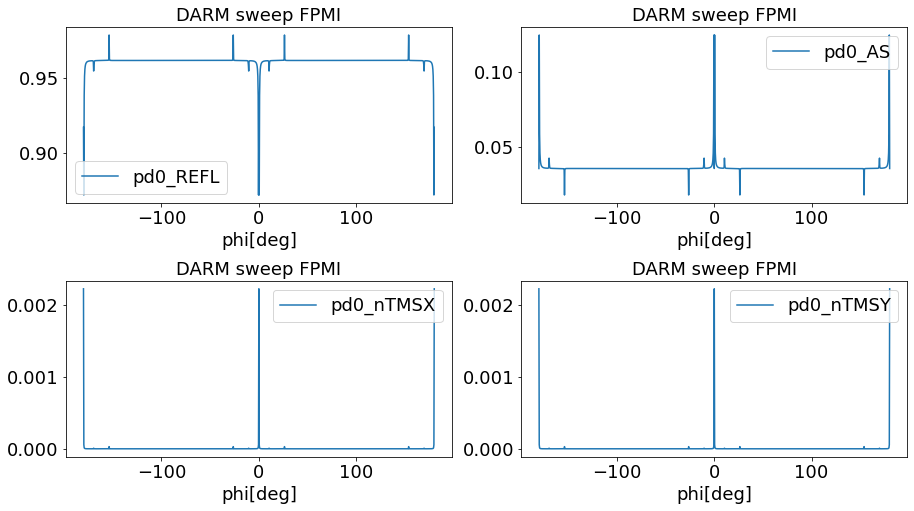

pd0


### FPMI

const fsb1 16.881M
const fsb2 45.0159M

# Input optics
l I_fsb1 1 0 n0
s s_eo0 0 n0 n_eo1
mod eom1 16.881M 0.3 1 pm n_eo1 n_eo2
s s_eo1 0 n_eo2 n_eo3
mod eom2 45.0159M 0.3 1 pm n_eo3 n_eo4
s s_eo2 0 n_eo4 REFL

# Michelson
bs bs1 0.5 0.5 0 45 REFL n2 n3 AS
s lx 26.6649 n3 nx1
s ly 23.3351 n2 ny1


# X arm
m ITMX 0.996 0.004 0 nx1 nx2
s sx1 3000 nx2 nx3
m ETMX 0.99995 5e-06 0 nx3 nTMSX

# Y arm
m ITMY 0.996 0.004 90 ny1 ny2
s sy1 3000 ny2 ny3
m ETMY 0.99995 5e-06 90 ny3 nTMSY

        
## PDs ##

pd0 pd0_REFL REFL
pd0 pd0_AS AS
pd0 pd0_nTMSX nTMSX
pd0 pd0_nTMSY nTMSY
            
# BS scan
#
#(koyama) original vergion log kokeyamasan uses xaxis*
# select xaxis plotscale "log" cause an error with xaxis*
# m ITMX 0.996 0.004 0 nx1 nx2
# since the config are above, I think it doesnt cause any problem about the correctness of the result
#

xaxis ITMX phi lin -180 180 1000
put* ITMY phi $mx1
put* ETMX phi $x1
put* ETMY phi $mx1
yaxis abs
            
-------------------------

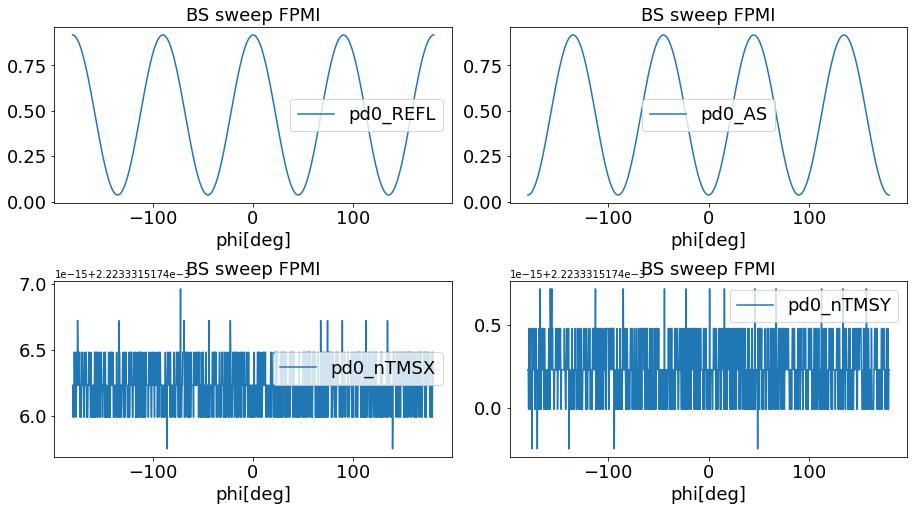

ad


### FPMI

const fsb1 16.881M
const fsb2 45.0159M

# Input optics
l I_fsb1 1 0 n0
s s_eo0 0 n0 n_eo1
mod eom1 16.881M 0.3 1 pm n_eo1 n_eo2
s s_eo1 0 n_eo2 n_eo3
mod eom2 45.0159M 0.3 1 pm n_eo3 n_eo4
s s_eo2 0 n_eo4 REFL

# Michelson
bs bs1 0.5 0.5 0 45 REFL n2 n3 AS
s lx 26.6649 n3 nx1
s ly 23.3351 n2 ny1


# X arm
m ITMX 0.996 0.004 0 nx1 nx2
s sx1 3000 nx2 nx3
m ETMX 0.99995 5e-06 0 nx3 nTMSX

# Y arm
m ITMY 0.996 0.004 90 ny1 ny2
s sy1 3000 ny2 ny3
m ETMY 0.99995 5e-06 90 ny3 nTMSY

        
## PDs ##

ad fsb1_ad_AS $fsb1 AS
ad fsb2_ad_AS $fsb2 AS
ad cr_ad_AS 0 AS
ad cr_ad_REFL 0 REFL
ad fsb2_ad_REFL $fsb2 REFL
ad fsb1_ad_REFL $fsb1 REFL
            
# BS scan
#
#(koyama) original vergion log kokeyamasan uses xaxis*
# select xaxis plotscale "log" cause an error with xaxis*
# m ITMX 0.996 0.004 0 nx1 nx2
# since the config are above, I think it doesnt cause any problem about the correctness of the result
#

xaxis ITMX phi lin -180 180 1000
put* ITMY phi $mx1
put* ETMX phi $x1
pu

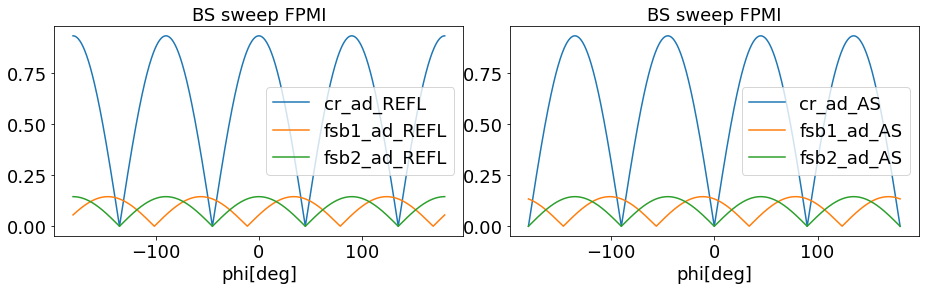

ad


### FPMI

const fsb1 16.881M
const fsb2 45.0159M

# Input optics
l I_fsb1 1 0 n0
s s_eo0 0 n0 n_eo1
mod eom1 16.881M 0.3 1 pm n_eo1 n_eo2
s s_eo1 0 n_eo2 n_eo3
mod eom2 45.0159M 0.3 1 pm n_eo3 n_eo4
s s_eo2 0 n_eo4 REFL

# Michelson
bs bs1 0.5 0.5 0 45 REFL n2 n3 AS
s lx 26.6649 n3 nx1
s ly 23.3351 n2 ny1


# X arm
m ITMX 0.996 0.004 0 nx1 nx2
s sx1 3000 nx2 nx3
m ETMX 0.99995 5e-06 0 nx3 nTMSX

# Y arm
m ITMY 0.996 0.004 90 ny1 ny2
s sy1 3000 ny2 ny3
m ETMY 0.99995 5e-06 90 ny3 nTMSY

        
## PDs ##

ad fsb1_ad_AS $fsb1 AS
ad fsb2_ad_AS $fsb2 AS
ad cr_ad_AS 0 AS
ad cr_ad_REFL 0 REFL
ad fsb2_ad_REFL $fsb2 REFL
ad fsb1_ad_REFL $fsb1 REFL
            
# BS scan
#
#(koyama) original vergion log kokeyamasan uses xaxis*
# select xaxis plotscale "log" cause an error with xaxis*
# m ITMX 0.996 0.004 0 nx1 nx2
# since the config are above, I think it doesnt cause any problem about the correctness of the result
#

xaxis ITMX phi lin -180 180 1000
put* ITMY phi $mx1
put* ETMX phi $x1
pu

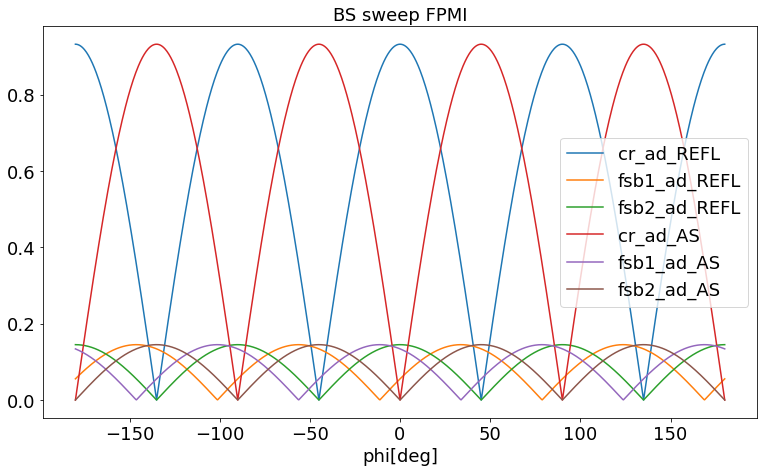

ad


### FPMI

const fsb1 16.881M
const fsb2 45.0159M

# Input optics
l I_fsb1 1 0 n0
s s_eo0 0 n0 n_eo1
mod eom1 16.881M 0.3 1 pm n_eo1 n_eo2
s s_eo1 0 n_eo2 n_eo3
mod eom2 45.0159M 0.3 1 pm n_eo3 n_eo4
s s_eo2 0 n_eo4 REFL

# Michelson
bs bs1 0.5 0.5 0 45 REFL n2 n3 AS
s lx 26.6649 n3 nx1
s ly 23.3351 n2 ny1


# X arm
m ITMX 0.996 0.004 0 nx1 nx2
s sx1 3000 nx2 nx3
m ETMX 0.99995 5e-06 0 nx3 nTMSX

# Y arm
m ITMY 0.996 0.004 90 ny1 ny2
s sy1 3000 ny2 ny3
m ETMY 0.99995 5e-06 90 ny3 nTMSY

        
## PDs ##

ad fsb1_ad_AS $fsb1 AS
ad fsb2_ad_AS $fsb2 AS
ad cr_ad_AS 0 AS
ad cr_ad_REFL 0 REFL
ad fsb2_ad_REFL $fsb2 REFL
ad fsb1_ad_REFL $fsb1 REFL
            
# DARM scan
xaxis ETMX phi lin -180 180 1000
put* ETMY phi $mx1
yaxis abs
            
--------------------------------------------------------------
Running kat - Started at 2020-10-01 12:15:48.155309
Used Finesse 2.3.1 at /Users/koyamanaoki/opt/anaconda3/envs/finesse/bin/kat

Finished in 0.075449 seconds
100% | ETA:  0:00:00 | Ca

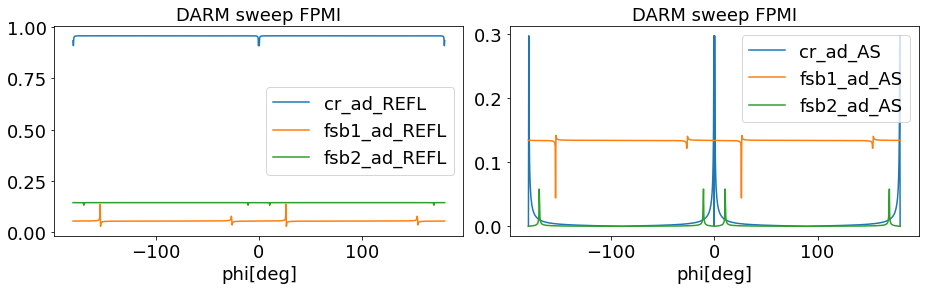

ad


### FPMI

const fsb1 16.881M
const fsb2 45.0159M

# Input optics
l I_fsb1 1 0 n0
s s_eo0 0 n0 n_eo1
mod eom1 16.881M 0.3 1 pm n_eo1 n_eo2
s s_eo1 0 n_eo2 n_eo3
mod eom2 45.0159M 0.3 1 pm n_eo3 n_eo4
s s_eo2 0 n_eo4 REFL

# Michelson
bs bs1 0.5 0.5 0 45 REFL n2 n3 AS
s lx 26.6649 n3 nx1
s ly 23.3351 n2 ny1


# X arm
m ITMX 0.996 0.004 0 nx1 nx2
s sx1 3000 nx2 nx3
m ETMX 0.99995 5e-06 0 nx3 nTMSX

# Y arm
m ITMY 0.996 0.004 90 ny1 ny2
s sy1 3000 ny2 ny3
m ETMY 0.99995 5e-06 90 ny3 nTMSY

        
## PDs ##

ad fsb1_ad_AS $fsb1 AS
ad fsb2_ad_AS $fsb2 AS
ad cr_ad_AS 0 AS
ad cr_ad_REFL 0 REFL
ad fsb2_ad_REFL $fsb2 REFL
ad fsb1_ad_REFL $fsb1 REFL
            
# CARM scan
#(koyama) xaxis*
#initial
# m ITMX 0.996 0.004 0 nx1 nx2
xaxis ETMX phi lin -180 180 1000
put* ETMY phi $x1
yaxis abs
            
--------------------------------------------------------------
Running kat - Started at 2020-10-01 12:16:06.737821
Used Finesse 2.3.1 at /Users/koyamanaoki/opt/anaconda3/envs/finesse/bin/kat

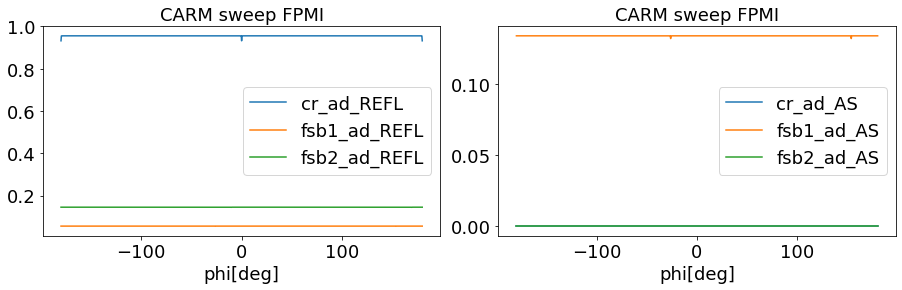

ad


### FPMI

const fsb1 16.881M
const fsb2 45.0159M

# Input optics
l I_fsb1 1 0 n0
s s_eo0 0 n0 n_eo1
mod eom1 16.881M 0.3 1 pm n_eo1 n_eo2
s s_eo1 0 n_eo2 n_eo3
mod eom2 45.0159M 0.3 1 pm n_eo3 n_eo4
s s_eo2 0 n_eo4 REFL

# Michelson
bs bs1 0.5 0.5 0 45 REFL n2 n3 AS
s lx 26.6649 n3 nx1
s ly 23.3351 n2 ny1


# X arm
m ITMX 0.996 0.004 0 nx1 nx2
s sx1 3000 nx2 nx3
m ETMX 0.99995 5e-06 0 nx3 nTMSX

# Y arm
m ITMY 0.996 0.004 90 ny1 ny2
s sy1 3000 ny2 ny3
m ETMY 0.99995 5e-06 90 ny3 nTMSY

        
## PDs ##

ad cr_ad_AS 0 AS
ad cr_ad_REFL 0 REFL
            
# CARM scan
#(koyama) xaxis*
#initial
# m ITMX 0.996 0.004 0 nx1 nx2
xaxis ETMX phi lin -180 180 1000
put* ETMY phi $x1
yaxis abs
            
--------------------------------------------------------------
Running kat - Started at 2020-10-01 12:16:16.048490
Used Finesse 2.3.1 at /Users/koyamanaoki/opt/anaconda3/envs/finesse/bin/kat

Finished in 0.062856 seconds
100% | ETA:  0:00:00 | Calculating

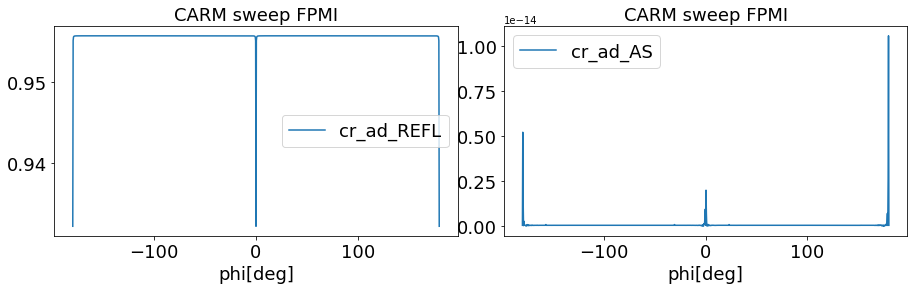

ad


### FPMI

const fsb1 16.881M
const fsb2 45.0159M

# Input optics
l I_fsb1 1 0 n0
s s_eo0 0 n0 n_eo1
mod eom1 16.881M 0.3 1 pm n_eo1 n_eo2
s s_eo1 0 n_eo2 n_eo3
mod eom2 45.0159M 0.3 1 pm n_eo3 n_eo4
s s_eo2 0 n_eo4 REFL

# Michelson
bs bs1 0.5 0.5 0 45 REFL n2 n3 AS
s lx 26.6649 n3 nx1
s ly 23.3351 n2 ny1


# X arm
m ITMX 0.996 0.004 0 nx1 nx2
s sx1 3000 nx2 nx3
m ETMX 0.99995 5e-06 0 nx3 nTMSX

# Y arm
m ITMY 0.996 0.004 90 ny1 ny2
s sy1 3000 ny2 ny3
m ETMY 0.99995 5e-06 90 ny3 nTMSY

        
## PDs ##

ad fsb1_ad_AS $fsb1 AS
ad fsb2_ad_AS $fsb2 AS
ad cr_ad_AS 0 AS
ad cr_ad_REFL 0 REFL
ad fsb2_ad_REFL $fsb2 REFL
ad fsb1_ad_REFL $fsb1 REFL
            
# CARM scan
#(koyama) xaxis*
#initial
# m ITMX 0.996 0.004 0 nx1 nx2
xaxis ETMX phi lin -180 180 1000
put* ETMY phi $x1
yaxis abs
            
--------------------------------------------------------------
Running kat - Started at 2020-10-01 12:16:21.945887
Used Finesse 2.3.1 at /Users/koyamanaoki/opt/anaconda3/envs/finesse/bin/kat

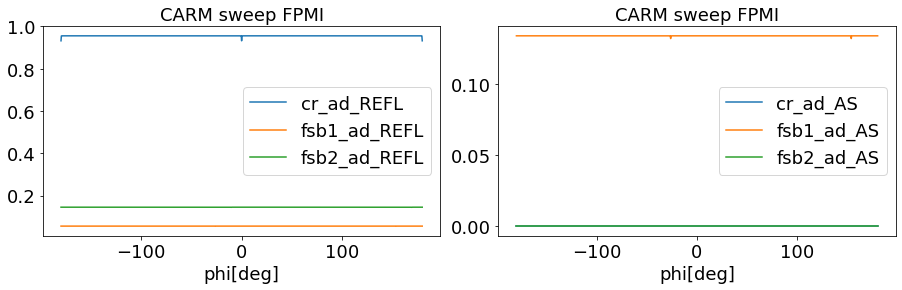

ad


### FPMI

const fsb1 16.881M
const fsb2 45.0159M

# Input optics
l I_fsb1 1 0 n0
s s_eo0 0 n0 n_eo1
mod eom1 16.881M 0.3 1 pm n_eo1 n_eo2
s s_eo1 0 n_eo2 n_eo3
mod eom2 45.0159M 0.3 1 pm n_eo3 n_eo4
s s_eo2 0 n_eo4 REFL

# Michelson
bs bs1 0.5 0.5 0 45 REFL n2 n3 AS
s lx 26.6649 n3 nx1
s ly 23.3351 n2 ny1


# X arm
m ITMX 0.996 0.004 0 nx1 nx2
s sx1 3000 nx2 nx3
m ETMX 0.99995 5e-06 0 nx3 nTMSX

# Y arm
m ITMY 0.996 0.004 90 ny1 ny2
s sy1 3000 ny2 ny3
m ETMY 0.99995 5e-06 90 ny3 nTMSY

        
## PDs ##

ad fsb1_ad_AS $fsb1 AS
ad cr_ad_AS 0 AS
ad fsb2_ad_AS $fsb2 AS
            
# CARM scan
#(koyama) xaxis*
#initial
# m ITMX 0.996 0.004 0 nx1 nx2
xaxis ETMX phi lin -180 180 1000
put* ETMY phi $x1
yaxis abs
            
--------------------------------------------------------------
Running kat - Started at 2020-10-01 12:16:30.294016
Used Finesse 2.3.1 at /Users/koyamanaoki/opt/anaconda3/envs/finesse/bin/kat

Finished in 0.0676601 seconds
100% | ETA:  0:00:00 | Calculating

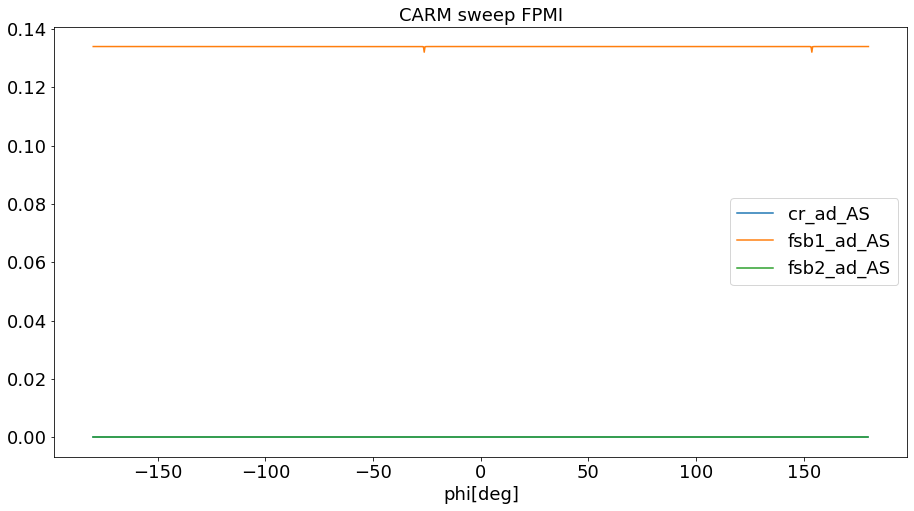

ad


### FPMI

const fsb1 16.881M
const fsb2 45.0159M

# Input optics
l I_fsb1 1 0 n0
s s_eo0 0 n0 n_eo1
mod eom1 16.881M 0.3 1 pm n_eo1 n_eo2
s s_eo1 0 n_eo2 n_eo3
mod eom2 45.0159M 0.3 1 pm n_eo3 n_eo4
s s_eo2 0 n_eo4 REFL

# Michelson
bs bs1 0.5 0.5 0 45 REFL n2 n3 AS
s lx 26.6649 n3 nx1
s ly 23.3351 n2 ny1


# X arm
m ITMX 0.996 0.004 0 nx1 nx2
s sx1 3000 nx2 nx3
m ETMX 0.99995 5e-06 0 nx3 nTMSX

# Y arm
m ITMY 0.996 0.004 90 ny1 ny2
s sy1 3000 ny2 ny3
m ETMY 0.99995 5e-06 90 ny3 nTMSY

        
## PDs ##

ad fsb1_ad_AS $fsb1 AS
            
# CARM scan
#(koyama) xaxis*
#initial
# m ITMX 0.996 0.004 0 nx1 nx2
xaxis ETMX phi lin -180 180 1000
put* ETMY phi $x1
yaxis abs
            
--------------------------------------------------------------
Running kat - Started at 2020-10-01 12:16:39.225858
Used Finesse 2.3.1 at /Users/koyamanaoki/opt/anaconda3/envs/finesse/bin/kat

Finished in 0.0547421 seconds
100% | ETA:  0:00:00 | Calculating

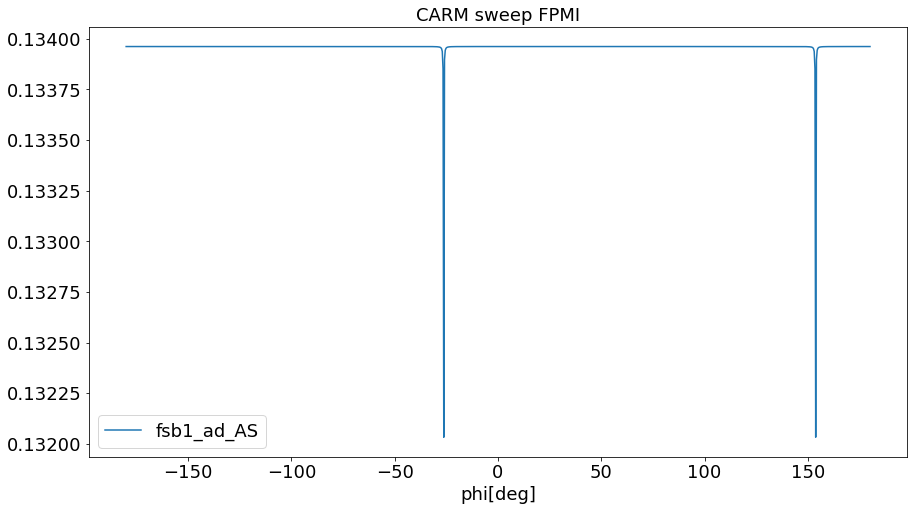

ad

# DRFPMI
#
# ======== Constants ========================
const fsb1 16.881M
const fsb2 45.0159M
const mfsb1 -16.881M
const mfsb2 -45.0159M
const a 0.686
const prc_loss 40e-6
const src_loss 40e-6

# ======== Input optics =====================
l i1 1 0 n0
s s_eo0 0 n0 n_eo1
mod eom1 $fsb1 0.3 1 pm n_eo1 n_eo2
s s_eo1 0 n_eo2 n_eo3
mod eom2 $fsb2 0.3 1 pm n_eo3 n_eo4
s s_eo2 0 n_eo4 REFL

## ======= PRC each mirror loss $prc_loss =======
# PRC
#m1 PRM 1 0e-6 0 REFL npr1
m1 PRM 0.1 $prc_loss 0 REFL npr1
s sLpr1 14.7615 npr1 npr2
bs1 PR2 500e-6 $prc_loss 0 $a npr3 npr2 POP POP2
s sLpr2 11.0661 npr3 npr4
bs1 PR3 50e-6 $prc_loss 0 $a dump dump npr4 npr5
s sLpr3 15.7638 npr5 npr6

# Michelson
bs bs1 0.5 0.5 0 45 npr6 n2 n3 n4
s lx 26.6649 n3 nx1
s ly 23.3351 n2 ny1

# X arm
m ITMX 0.996 0.004 0 nx1 nx2
s sx1 3000 nx2 nx3
m ETMX 0.999995 5e-06 0 nx3 nTMSX

# Y arm
m ITMY 0.996 0.004 90 ny1 ny2
s sy1 3000 ny2 ny3
m ETMY 0.999995 5e-06 90 ny3 nTMSY

# ========= SRC each mirror loss 45ppm ====

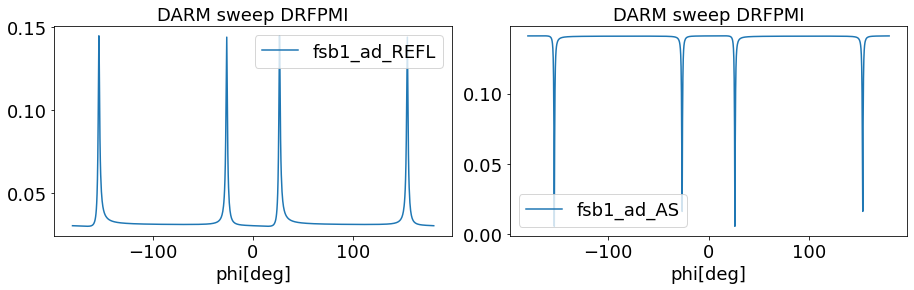

ad

# DRFPMI
#
# ======== Constants ========================
const fsb1 16.881M
const fsb2 45.0159M
const mfsb1 -16.881M
const mfsb2 -45.0159M
const a 0.686
const prc_loss 40e-6
const src_loss 40e-6

# ======== Input optics =====================
l i1 1 0 n0
s s_eo0 0 n0 n_eo1
mod eom1 $fsb1 0.3 1 pm n_eo1 n_eo2
s s_eo1 0 n_eo2 n_eo3
mod eom2 $fsb2 0.3 1 pm n_eo3 n_eo4
s s_eo2 0 n_eo4 REFL

## ======= PRC each mirror loss $prc_loss =======
# PRC
#m1 PRM 1 0e-6 0 REFL npr1
m1 PRM 0.1 $prc_loss 0 REFL npr1
s sLpr1 14.7615 npr1 npr2
bs1 PR2 500e-6 $prc_loss 0 $a npr3 npr2 POP POP2
s sLpr2 11.0661 npr3 npr4
bs1 PR3 50e-6 $prc_loss 0 $a dump dump npr4 npr5
s sLpr3 15.7638 npr5 npr6

# Michelson
bs bs1 0.5 0.5 0 45 npr6 n2 n3 n4
s lx 26.6649 n3 nx1
s ly 23.3351 n2 ny1

# X arm
m ITMX 0.996 0.004 0 nx1 nx2
s sx1 3000 nx2 nx3
m ETMX 0.999995 5e-06 0 nx3 nTMSX

# Y arm
m ITMY 0.996 0.004 90 ny1 ny2
s sy1 3000 ny2 ny3
m ETMY 0.999995 5e-06 90 ny3 nTMSY

# ========= SRC each mirror loss 45ppm ====

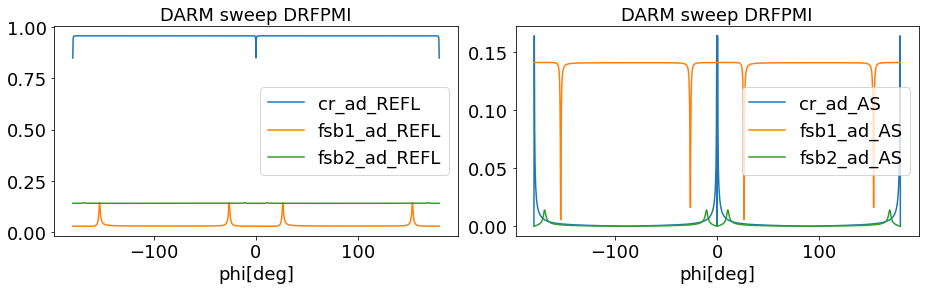

Exception in Tkinter callback
Traceback (most recent call last):
  File "/Users/koyamanaoki/opt/anaconda3/envs/finesse/lib/python3.8/tkinter/__init__.py", line 1883, in __call__
    return self.func(*args)
  File "/Users/koyamanaoki/opt/anaconda3/envs/finesse/lib/python3.8/tkinter/__init__.py", line 3525, in set
    self.tk.call(self._w, 'set', first, last)
_tkinter.TclError: invalid command name ".!toplevel19.!frame.!tkscrollableframe.!scrollbar"
Exception in Tkinter callback
Traceback (most recent call last):
  File "/Users/koyamanaoki/opt/anaconda3/envs/finesse/lib/python3.8/tkinter/__init__.py", line 1883, in __call__
    return self.func(*args)
  File "/Users/koyamanaoki/opt/anaconda3/envs/finesse/lib/python3.8/tkinter/__init__.py", line 3525, in set
    self.tk.call(self._w, 'set', first, last)
_tkinter.TclError: invalid command name ".!toplevel19.!frame.!tkscrollableframe.!scrollbar"


In [14]:

######################################################################################################################################################
# GUIを作成
######################################################################################################################################################

##################################
# drawing
##################################
# FPMI
kFPMI_drawing_normalsize = [
                [sg.Image('./devel/FPMI_picture_normal.png', key='kFPMI_imageContainer',  size=(400,300))]#size=(800,600)
]
kFPMI_drawing_largesize = [
                [sg.Image('./devel/FPMI_picture_large.png', key='kFPMI_imageContainer2', size=(800,600))]#size=(800,600)
]

# PRFPMI
kPRFPMI_drawing_normalsize = [
                [sg.Image('./devel/PRFPMI_picture_normal.png', key='kPRFPMI_imageContainer',  size=(400,300))]#size=(800,600)
]
kPRFPMI_drawing_largesize = [
                [sg.Image('./devel/PRFPMI_picture_large.png', key='kPRFPMI_imageContainer2', size=(800,600))]#size=(800,600)
]
# kDRFPMI
kDRFPMI_drawing_normalsize = [
                [sg.Image('./devel/DRFPMI_picture_normal.png', key='kDRFPMI_imageContainer',  size=(400,300))]#size=(800,600)
]
kDRFPMI_drawing_largesize = [
                [sg.Image('./devel/DRFPMI_picture_large.png', key='kDRFPMI_imageContainer2', size=(800,600))]#size=(800,600)
]
# kMI
kMI_drawing_normalsize = [
                [sg.Image('./devel/MI_picture_normal.png', key='kMI_imageContainer',  size=(400,300))]#size=(800,600)
]
kMI_drawing_largesize = [
                [sg.Image('./devel/MI_picture_large.png', key='kMI_imageContainer2', size=(800,600))]#size=(800,600)
]
##################################
# drawing size buttons
##################################
# kFPMI
kFPMI_drawing_size_buttons =[
                [sg.Button('normal size', size=(10,1), font=(10), key='kFPMI_normalize_drawing_size'),
                 sg.Button('Large size',  size=(10,1), font=(10), key='kFPMI_expand_drawing_size')],
]
# kPRFPMI
kPRFPMI_drawing_size_buttons =[
                [sg.Button('normal size', size=(10,1), font=(10), key='kPRFPMI_normalize_drawing_size'),
                 sg.Button('Large size',  size=(10,1), font=(10), key='kPRFPMI_expand_drawing_size')],
]
# kDRFPMI
kDRFPMI_drawing_size_buttons =[
                [sg.Button('normal size', size=(10,1), font=(10), key='kDRFPMI_normalize_drawing_size'),
                 sg.Button('Large size',  size=(10,1), font=(10), key='kDRFPMI_expand_drawing_size')],
]
# kMI
kMI_drawing_size_buttons =[
                [sg.Button('normal size', size=(10,1), font=(10), key='kMI_normalize_drawing_size'),
                 sg.Button('Large size',  size=(10,1), font=(10), key='kMI_expand_drawing_size')],
]
##################################
#section setting pd0/pd1/pd2
##################################

#
# kFPMI
#

# select sw_power or sw_dmod1
kFPMI_sec_sw_power_setting = [
            [sg.Text('no advanced settings')]
            ]
kFPMI_sec_sw_amptd_setting = [
            # amp detecter
            [sg.Checkbox('see amp of CR',    key='kFPMI_put_cr_sw_amptd_flag'),
             sg.Checkbox('see amp of freq1', key='kFPMI_put_f1_sw_amptd_flag'),
             sg.Checkbox('see amp of freq2', key='kFPMI_put_f2_sw_amptd_flag')],
            ]
kFPMI_sec_sw_dmod1_setting = [
    
            [sg.Text('if select "plot separately", pd results displayed all separately.')],
            [sg.Radio('overplot selected port', 'RADIO_sw_dmod1_plot', default=False, key='kFPMI_sw_dmod1_overplot', enable_events=True),
             sg.Radio('plot separately',        'RADIO_sw_dmod1_plot', default=True,  key='kFPMI_sw_dmod1_sepaplot', enable_events=True)],
            [sg.Text('Which phase to plot?')],
            [sg.Checkbox('I_fsb1(in_phase f1)',         key='kFPMI_pd1_Iphase_fsb1'),
             sg.Checkbox('Q_fsb1(quadrature_phase f1)', key='kFPMI_pd1_Qphase_fsb1'),
             sg.Checkbox('I_fsb2(in_phase f2)',         key='kFPMI_pd1_Iphase_fsb2'),
             sg.Checkbox('Q_fsb2(quadrature_phase f2)', key='kFPMI_pd1_Qphase_fsb2')],
    
            [sg.Text('Demodulation_phase'),sg.Input(key='kFPMI_pd1_demod_phase', default_text='0', enable_events=True)]
            ]

# select tf_power or tf_dmod2
kFPMI_sec_tf_power_setting = [
            [sg.Text('no advanced settings')]
            ]
kFPMI_sec_tf_amptd_setting = [
            [sg.Checkbox('see amp of CR',    key='kFPMI_put_cr_tf_amptd_flag'),
             sg.Checkbox('see amp of freq1', key='kFPMI_put_f1_tf_amptd_flag'),
             sg.Checkbox('see amp of freq2', key='kFPMI_put_f2_tf_amptd_flag')],
            ]
kFPMI_sec_tf_dmod2_setting = [
    
            [sg.Text('if select "plot separately", pd results displayed all separately.')],
            [sg.Radio('overplot selected port', 'RADIO_tf_dmod2_plot', default=False, key='kFPMI_tf_dmod2_overplot', enable_events=True),
             sg.Radio('plot separately',        'RADIO_tf_dmod2_plot', default=True,  key='kFPMI_tf_dmod2_sepaplot', enable_events=True)],
            [sg.Text('Which phase to plot?')],
            [sg.Checkbox('I_fsb1(in_phase f1)',         key='kFPMI_pd2_Iphase_fsb1'),
             sg.Checkbox('Q_fsb1(quadrature_phase f1)', key='kFPMI_pd2_Qphase_fsb1'),
             sg.Checkbox('I_fsb2(in_phase f2)',         key='kFPMI_pd2_Iphase_fsb2'),
             sg.Checkbox('Q_fsb2(quadrature_phase f2)', key='kFPMI_pd2_Qphase_fsb2'),],
    
            [sg.Text('Demodulation_phase'),sg.Input(key='kFPMI_pd2_demod_phase', default_text='0', enable_events=True)]
            ]

# select sw or tf
kFPMI_sec_sw_setting = [
            
            [sg.Text('Select pd0 or pd1.')],
            [sg.Radio('Power(pd0)',        'kFPMI_sw_RADIO', default=True,  key='kFPMI_issw_power', enable_events=True),
             sg.Radio('amplitude detecter','kFPMI_sw_RADIO', default=False, key='kFPMI_issw_amptd', enable_events=True),
             sg.Radio('Demod_once(pd1)',   'kFPMI_sw_RADIO', default=False, key='kFPMI_issw_dmod1', enable_events=True)],
    
            ### pd0_setting_section
            [collapse(kFPMI_sec_sw_power_setting, 'kFPMI_sec_sw_power_setting')],
            ### amplitude detecter
            [collapse(kFPMI_sec_sw_amptd_setting, 'kFPMI_sec_sw_amptd_setting')],
            ### pd1_settnig_section
            [collapse(kFPMI_sec_sw_dmod1_setting, 'kFPMI_sec_sw_dmod1_setting')]
    
            ]

kFPMI_sec_tf_setting = [
            
            [sg.Text('Select pd0 or pd2.')],
            [sg.Radio('Power(pd0)',        'kFPMI_tf_RADIO', default=True,  key='kFPMI_istf_power', enable_events=True),
             sg.Radio('amplitude detecter','kFPMI_tf_RADIO', default=False, key='kFPMI_istf_amptd', enable_events=True),
             sg.Radio('Demod(pd2)',        'kFPMI_tf_RADIO', default=False, key='kFPMI_istf_dmod2', enable_events=True)],

            ### pd2_setting_section
            [collapse(kFPMI_sec_tf_power_setting, 'kFPMI_sec_tf_power_setting')],
            ### amplitude detecter
            [collapse(kFPMI_sec_tf_amptd_setting, 'kFPMI_sec_tf_amptd_setting')],
            ### pd2_setting_section
            [collapse(kFPMI_sec_tf_dmod2_setting, 'kFPMI_sec_tf_dmod2_setting')]
    
            ]

#
# kPRFPMI
#

kPRFPMI_sec_sw_power_setting = [

            [sg.Text('no advanced settings')]
            ]
kPRFPMI_sec_sw_amptd_setting = [
            # amp detecter
            [sg.Checkbox('see amp of CR',    key='kPRFPMI_put_cr_sw_amptd_flag'),
             sg.Checkbox('see amp of freq1', key='kPRFPMI_put_f1_sw_amptd_flag'),
             sg.Checkbox('see amp of freq2', key='kPRFPMI_put_f2_sw_amptd_flag')],
            ]
kPRFPMI_sec_sw_dmod1_setting = [
    
            [sg.Text('if select "plot separately", pd results displayed all separately.')],
            [sg.Radio('overplot selected port', 'RADIO_sw_dmod1_plot', default=False, key='kPRFPMI_sw_dmod1_overplot', enable_events=True),
             sg.Radio('plot separately',        'RADIO_sw_dmod1_plot', default=True,  key='kPRFPMI_sw_dmod1_sepaplot', enable_events=True)],
            [sg.Text('Which phase to plot?')],

            [sg.Checkbox('I_fsb1(in_phase f1)',         key='kPRFPMI_pd1_Iphase_fsb1'),
             sg.Checkbox('Q_fsb1(quadrature_phase f1)', key='kPRFPMI_pd1_Qphase_fsb1'),
             sg.Checkbox('I_fsb2(in_phase f2)',         key='kPRFPMI_pd1_Iphase_fsb2'),
             sg.Checkbox('Q_fsb2(quadrature_phase f2)', key='kPRFPMI_pd1_Qphase_fsb2')],
    
            [sg.Text('Demodulation_phase'),sg.Input(key='kPRFPMI_pd1_demod_phase', default_text='0', enable_events=True)]
            ]

# select tf_power or tf_dmod2
kPRFPMI_sec_tf_power_setting = [

            [sg.Text('no advanced settings')]
            ]
kPRFPMI_sec_tf_amptd_setting = [
            # amp detecter
            [sg.Checkbox('see amp of CR',    key='kPRFPMI_put_cr_tf_amptd_flag'),
             sg.Checkbox('see amp of freq1', key='kPRFPMI_put_f1_tf_amptd_flag'),
             sg.Checkbox('see amp of freq2', key='kPRFPMI_put_f2_tf_amptd_flag')],
            ]
kPRFPMI_sec_tf_dmod2_setting = [
    
            [sg.Text('if select "plot separately", pd results displayed all separately.')],
            [sg.Radio('overplot selected port', 'RADIO_tf_dmod2_plot', default=False, key='kPRFPMI_tf_dmod2_overplot', enable_events=True),
             sg.Radio('plot separately',        'RADIO_tf_dmod2_plot', default=True,  key='kPRFPMI_tf_dmod2_sepaplot', enable_events=True)],
            [sg.Text('Which phase to plot?')],

            [sg.Checkbox('I_fsb1(in_phase f1)',         key='kPRFPMI_pd2_Iphase_fsb1'),
             sg.Checkbox('Q_fsb1(quadrature_phase f1)', key='kPRFPMI_pd2_Qphase_fsb1'),
             sg.Checkbox('I_fsb2(in_phase f2)',         key='kPRFPMI_pd2_Iphase_fsb2'),
             sg.Checkbox('Q_fsb2(quadrature_phase f2)', key='kPRFPMI_pd2_Qphase_fsb2'),],
    
            [sg.Text('Demodulation_phase'),sg.Input(key='kPRFPMI_pd2_demod_phase', default_text='0', enable_events=True)]
            ]

# select sw or tf
kPRFPMI_sec_sw_setting = [
    
            [sg.Text('Select pd0 or pd1.')],
            [sg.Radio('Power(pd0)',        'kPRFPMI_sw_RADIO', default=True,  key='kPRFPMI_issw_power', enable_events=True),
             sg.Radio('amplitude detecter','kPRFPMI_sw_RADIO', default=False, key='kPRFPMI_issw_amptd', enable_events=True),
             sg.Radio('Demod_once(pd1)',   'kPRFPMI_sw_RADIO', default=False, key='kPRFPMI_issw_dmod1', enable_events=True)],
    
            ### pd0_setting_section
            [collapse(kPRFPMI_sec_sw_power_setting, 'kPRFPMI_sec_sw_power_setting')],
            ### amplitude detecter
            [collapse(kPRFPMI_sec_sw_amptd_setting, 'kPRFPMI_sec_sw_amptd_setting')],
            ### pd1_settnig_section
            [collapse(kPRFPMI_sec_sw_dmod1_setting, 'kPRFPMI_sec_sw_dmod1_setting')]
    
            ]

kPRFPMI_sec_tf_setting = [
    
            [sg.Text('Select pd0 or pd2.')],
            [sg.Radio('Power(pd0)',        'kPRFPMI_tf_RADIO', default=True,  key='kPRFPMI_istf_power', enable_events=True),
             sg.Radio('amplitude detecter','kPRFPMI_tf_RADIO', default=False, key='kPRFPMI_istf_amptd', enable_events=True),
             sg.Radio('Demod(pd2)',        'kPRFPMI_tf_RADIO', default=False, key='kPRFPMI_istf_dmod2', enable_events=True)],

            ### pd2_setting_section
            [collapse(kPRFPMI_sec_tf_power_setting, 'kPRFPMI_sec_tf_power_setting')],
            ### amplitude detecter
            [collapse(kPRFPMI_sec_tf_amptd_setting, 'kPRFPMI_sec_tf_amptd_setting')],
            ### pd2_setting_section
            [collapse(kPRFPMI_sec_tf_dmod2_setting, 'kPRFPMI_sec_tf_dmod2_setting')]
    
            ]

#
# kDRFPMI
#

kDRFPMI_sec_sw_power_setting = [
            [sg.Text('no advanced settings')]
            ]
kDRFPMI_sec_sw_amptd_setting = [
            # amp detecter
            [sg.Checkbox('see amp of CR',    key='kDRFPMI_put_cr_sw_amptd_flag'),
             sg.Checkbox('see amp of freq1', key='kDRFPMI_put_f1_sw_amptd_flag'),
             sg.Checkbox('see amp of freq2', key='kDRFPMI_put_f2_sw_amptd_flag')]
            ]
kDRFPMI_sec_sw_dmod1_setting = [
    
            [sg.Text('if select "plot separately", pd results displayed all separately.')],
            [sg.Radio('overplot selected port', 'RADIO_sw_dmod1_plot', default=False, key='kDRFPMI_sw_dmod1_overplot', enable_events=True),
             sg.Radio('plot separately',        'RADIO_sw_dmod1_plot', default=True,  key='kDRFPMI_sw_dmod1_sepaplot', enable_events=True)],
            [sg.Text('Which phase to plot?')],

            [sg.Checkbox('I_fsb1(in_phase f1)',         key='kDRFPMI_pd1_Iphase_fsb1'),
             sg.Checkbox('Q_fsb1(quadrature_phase f1)', key='kDRFPMI_pd1_Qphase_fsb1'),
             sg.Checkbox('I_fsb2(in_phase f2)',         key='kDRFPMI_pd1_Iphase_fsb2'),
             sg.Checkbox('Q_fsb2(quadrature_phase f2)', key='kDRFPMI_pd1_Qphase_fsb2')],
    
            [sg.Text('Demodulation_phase'),sg.Input(key='kDRFPMI_pd1_demod_phase', default_text='0', enable_events=True)]
            ]

# select tf_power or tf_dmod2
kDRFPMI_sec_tf_power_setting = [
            [sg.Text('no advanced settings')]

            ]
kDRFPMI_sec_tf_amptd_setting = [
            # amp detecter
            [sg.Checkbox('see amp of CR',    key='kDRFPMI_put_cr_tf_amptd_flag'),
             sg.Checkbox('see amp of freq1', key='kDRFPMI_put_f1_tf_amptd_flag'),
             sg.Checkbox('see amp of freq2', key='kDRFPMI_put_f2_tf_amptd_flag')],
            ]
kDRFPMI_sec_tf_dmod2_setting = [
    
            [sg.Text('if select "plot separately", pd results displayed all separately.')],
            [sg.Radio('overplot selected port', 'RADIO_tf_dmod2_plot', default=False, key='kDRFPMI_tf_dmod2_overplot', enable_events=True),
             sg.Radio('plot separately',        'RADIO_tf_dmod2_plot', default=True,  key='kDRFPMI_tf_dmod2_sepaplot', enable_events=True)],
            [sg.Text('Which phase to plot?')],

            [sg.Checkbox('I_fsb1(in_phase f1)',         key='kDRFPMI_pd2_Iphase_fsb1'),
             sg.Checkbox('Q_fsb1(quadrature_phase f1)', key='kDRFPMI_pd2_Qphase_fsb1'),
             sg.Checkbox('I_fsb2(in_phase f2)',         key='kDRFPMI_pd2_Iphase_fsb2'),
             sg.Checkbox('Q_fsb2(quadrature_phase f2)', key='kDRFPMI_pd2_Qphase_fsb2'),],
    
            [sg.Text('Demodulation_phase'),sg.Input(key='kDRFPMI_pd2_demod_phase', default_text='0', enable_events=True)]
            ]

# select sw or tf
kDRFPMI_sec_sw_setting = [
    
            [sg.Text('Select pd0 or pd1.')],
            [sg.Radio('Power(pd0)',        'kDRFPMI_sw_RADIO', default=True,  key='kDRFPMI_issw_power', enable_events=True),
             sg.Radio('amplitude detecter','kDRFPMI_sw_RADIO', default=False, key='kDRFPMI_issw_amptd', enable_events=True),
             sg.Radio('Demod_once(pd1)',   'kDRFPMI_sw_RADIO', default=False, key='kDRFPMI_issw_dmod1', enable_events=True)],
    
            ### pd0_setting_section
            [collapse(kDRFPMI_sec_sw_power_setting, 'kDRFPMI_sec_sw_power_setting')],
            ### amplitude detecter
            [collapse(kDRFPMI_sec_sw_amptd_setting, 'kDRFPMI_sec_sw_amptd_setting')],
            ### pd1_settnig_section
            [collapse(kDRFPMI_sec_sw_dmod1_setting, 'kDRFPMI_sec_sw_dmod1_setting')]
    
            ]

kDRFPMI_sec_tf_setting = [
    
            [sg.Text('Select pd0 or pd2.')],
            [sg.Radio('Power(pd0)',        'kDRFPMI_tf_RADIO', default=True,  key='kDRFPMI_istf_power', enable_events=True),
             sg.Radio('amplitude detecter','kDRFPMI_tf_RADIO', default=False, key='kDRFPMI_istf_amptd', enable_events=True),
             sg.Radio('Demod(pd2)',        'kDRFPMI_tf_RADIO', default=False, key='kDRFPMI_istf_dmod2', enable_events=True)],

            ### pd2_setting_section
            [collapse(kDRFPMI_sec_tf_power_setting, 'kDRFPMI_sec_tf_power_setting')],
            ### amplitude detecter
            [collapse(kDRFPMI_sec_tf_amptd_setting, 'kDRFPMI_sec_tf_amptd_setting')],
            ### pd2_setting_section
            [collapse(kDRFPMI_sec_tf_dmod2_setting, 'kDRFPMI_sec_tf_dmod2_setting')]
    
            ]

#
# kMI
#

kMI_sec_sw_power_setting = [
            [sg.Text('no advanced settings')]

            ]
kMI_sec_sw_amptd_setting = [
            # amp detecter
            [sg.Checkbox('see amp of CR',    key='kMI_put_cr_sw_amptd_flag'),
             sg.Checkbox('see amp of freq1', key='kMI_put_f1_sw_amptd_flag'),
             sg.Checkbox('see amp of freq2', key='kMI_put_f2_sw_amptd_flag')]
            ]
kMI_sec_sw_dmod1_setting = [
    
            [sg.Text('if select "plot separately", pd results displayed all separately.')],
            [sg.Radio('overplot selected port', 'RADIO_sw_dmod1_plot', default=False, key='kMI_sw_dmod1_overplot', enable_events=True),
             sg.Radio('plot separately',        'RADIO_sw_dmod1_plot', default=True,  key='kMI_sw_dmod1_sepaplot', enable_events=True)],
            [sg.Text('Which phase to plot?')],

            [sg.Checkbox('I_fsb1(in_phase f1)',         key='kMI_pd1_Iphase_fsb1'),
             sg.Checkbox('Q_fsb1(quadrature_phase f1)', key='kMI_pd1_Qphase_fsb1'),
             sg.Checkbox('I_fsb2(in_phase f2)',         key='kMI_pd1_Iphase_fsb2'),
             sg.Checkbox('Q_fsb2(quadrature_phase f2)', key='kMI_pd1_Qphase_fsb2')],
    
            [sg.Text('Demodulation_phase'),sg.Input(key='kMI_pd1_demod_phase', default_text='0', enable_events=True)]
            ]

# select tf_power or tf_dmod2
kMI_sec_tf_power_setting = [
            [sg.Text('no advanced settings')]

            ]
kMI_sec_tf_amptd_setting = [
            # amp detecter
            [sg.Checkbox('see amp of CR',    key='kMI_put_cr_tf_amptd_flag'),
             sg.Checkbox('see amp of freq1', key='kMI_put_f1_tf_amptd_flag'),
             sg.Checkbox('see amp of freq2', key='kMI_put_f2_tf_amptd_flag')],
            ]
kMI_sec_tf_dmod2_setting = [
    
            [sg.Text('if select "plot separately", pd results displayed all separately.')],
            [sg.Radio('overplot selected port', 'RADIO_tf_dmod2_plot', default=False, key='kMI_tf_dmod2_overplot', enable_events=True),
             sg.Radio('plot separately',        'RADIO_tf_dmod2_plot', default=True,  key='kMI_tf_dmod2_sepaplot', enable_events=True)],
            [sg.Text('Which phase to plot?')],

            [sg.Checkbox('I_fsb1(in_phase f1)',         key='kMI_pd2_Iphase_fsb1'),
             sg.Checkbox('Q_fsb1(quadrature_phase f1)', key='kMI_pd2_Qphase_fsb1'),
             sg.Checkbox('I_fsb2(in_phase f2)',         key='kMI_pd2_Iphase_fsb2'),
             sg.Checkbox('Q_fsb2(quadrature_phase f2)', key='kMI_pd2_Qphase_fsb2'),],
    
            [sg.Text('Demodulation_phase'),sg.Input(key='kMI_pd2_demod_phase', default_text='0', enable_events=True)]
            ]

# select sw or tf
kMI_sec_sw_setting = [
    
            [sg.Text('Select pd0 or pd1.')],
            [sg.Radio('Power(pd0)',        'kMI_sw_RADIO', default=True,  key='kMI_issw_power', enable_events=True),
             sg.Radio('amplitude detecter','kMI_sw_RADIO', default=False, key='kMI_issw_amptd', enable_events=True),
             sg.Radio('Demod_once(pd1)',   'kMI_sw_RADIO', default=False, key='kMI_issw_dmod1', enable_events=True)],
    
            ### pd0_setting_section
            [collapse(kMI_sec_sw_power_setting, 'kMI_sec_sw_power_setting')],
            ### amplitude detecter
            [collapse(kMI_sec_sw_amptd_setting, 'kMI_sec_sw_amptd_setting')],
            ### pd1_settnig_section
            [collapse(kMI_sec_sw_dmod1_setting, 'kMI_sec_sw_dmod1_setting')]
    
            ]

kMI_sec_tf_setting = [
    
            [sg.Text('Select pd0 or pd2.')],
            [sg.Radio('Power(pd0)',        'kMI_tf_RADIO', default=True,  key='kMI_istf_power', enable_events=True),
             sg.Radio('amplitude detecter','kMI_tf_RADIO', default=False, key='kMI_istf_amptd', enable_events=True),
             sg.Radio('Demod(pd2)',        'kMI_tf_RADIO', default=False, key='kMI_istf_dmod2', enable_events=True)],

            ### pd2_setting_section
            [collapse(kMI_sec_tf_power_setting, 'kMI_sec_tf_power_setting')],
            ### amplitude detecter
            [collapse(kMI_sec_tf_amptd_setting, 'kMI_sec_tf_amptd_setting')],
            ### pd2_setting_section
            [collapse(kMI_sec_tf_dmod2_setting, 'kMI_sec_tf_dmod2_setting')]
    
            ]
##################################
#TAB select FPMI/PRFPMI/DRFPMI
##################################

#
#kFPMI_tab
#

kFPMI_layout = [
[collapse(kFPMI_drawing_normalsize, 'kFPMI_drawing_normalsize')],
[collapse(kFPMI_drawing_largesize,  'kFPMI_drawing_largesize')],
# Drawing
[sg.Column(kFPMI_drawing_size_buttons, justification="right")],
### select section sw or tf / power, dmod1 or dmod2
[sg.Text('1. Select Sweep or Transfer function', font=('System',20))],
[sg.Radio('Sweep',                  'HOW_SIMULATE01', default=True,  key='kFPMI_issw', enable_events=True),
 sg.Radio('Transfer function(pd2)', 'HOW_SIMULATE01', default=False, key='kFPMI_istf', enable_events=True)],

[collapse(kFPMI_sec_sw_setting, 'kFPMI_sec_sw_setting')],
[collapse(kFPMI_sec_tf_setting, 'kFPMI_sec_tf_setting')],

# select DARM, CARM or BS
[sg.Text('2. Select which Dof to move', font=('System',20))],
[sg.Text("note: Please do not type DoF, just select it from choices.")],
[sg.Text('　　DoF'),sg.Combo(('DARM', 'CARM', 'BS'), size=(20,1), default_value='DARM', key='kFPMI_dof')], #sg.comboを使う時にはサイズを指定するべき

## PDs checkbox
[sg.Text('3. Select port (see the top figure)', font=('System',20))],#図と関連あるとかく

[sg.Checkbox('REFL', default=True, key='kFPMI_REFL'), sg.Checkbox('AS',    default=True, key='kFPMI_AS'),
sg.Checkbox('nTMSY', default=True, key='kFPMI_nTMSY'),sg.Checkbox('nTMSX', default=True, key='kFPMI_nTMSX')],

[sg.Checkbox('n0',   key='kFPMI_n0'),
 sg.Checkbox('n_eo1',key='kFPMI_n_eo1'),sg.Checkbox('n_eo2',key='kFPMI_n_eo2'),
 sg.Checkbox('n_eo3',key='kFPMI_n_eo3'),sg.Checkbox('n_eo4',key='kFPMI_n_eo4')],
[sg.Checkbox('n2',   key='kFPMI_n2'),  sg.Checkbox('n3',  key='kFPMI_n3'),
 sg.Checkbox('ny1',  key='kFPMI_ny1'), sg.Checkbox('nx1', key='kFPMI_nx1'),
 sg.Checkbox('ny2',  key='kFPMI_ny2'), sg.Checkbox('nx2', key='kFPMI_nx2'),
 sg.Checkbox('ny3',  key='kFPMI_ny3'), sg.Checkbox('nx3', key='kFPMI_nx3')],
# plot button
[sg.Button('Plot', button_color=('white', 'black'), key='kFPMI_event'),
 sg.Text("     "),
 sg.Button('Check all important port', key='kFPMI_set_all_important_port_bool'),
 sg.Button(  'Check all port',         key='kFPMI_check_all_port'),
 sg.Button('Uncheck all port',         key='kFPMI_uncheck_all_port')]
]

#
#kPRFPMI
#

kPRFPMI_layout = [
[collapse(kPRFPMI_drawing_normalsize, 'kPRFPMI_drawing_normalsize')],
[collapse(kPRFPMI_drawing_largesize,  'kPRFPMI_drawing_largesize')],

# Drawing
[sg.Column(kPRFPMI_drawing_size_buttons, justification="right")],
### select section sw or tf / power, dmod1 or dmod2
[sg.Text('1. Select Sweep or Transfer function ', font=('System',20))],
[sg.Radio('Sweep',                  'HOW_SIMULATE01', default=True,  key='kPRFPMI_issw', enable_events=True),
 sg.Radio('Transfer function(pd2)', 'HOW_SIMULATE01', default=False, key='kPRFPMI_istf', enable_events=True)],

[collapse(kPRFPMI_sec_sw_setting, 'kPRFPMI_sec_sw_setting')],
[collapse(kPRFPMI_sec_tf_setting, 'kPRFPMI_sec_tf_setting')],

# select DARM, CARM or BS
[sg.Text('2. Select which Dof to move', font=('System',20))],
[sg.Text('　　DoF'),sg.Combo(('DARM', 'CARM', 'BS', 'PRCL'), size=(20,1), default_value='DARM', key='kPRFPMI_dof')], #sg.comboを使う時にはサイズを指定するべき

## PDs checkbox
[sg.Text('3. Select port (see the top figure)', font=('System',20))],#図と関連あるとかく

[sg.Checkbox('REFL', default=True, key='kPRFPMI_REFL'), sg.Checkbox('AS',    default=True, key='kPRFPMI_AS'),
 sg.Checkbox('POP',  default=True, key='kPRFPMI_POP'),
 sg.Checkbox('nTMSY',default=True, key='kPRFPMI_nTMSY'),sg.Checkbox('nTMSX', default=True, key='kPRFPMI_nTMSX')],
[sg.Checkbox('n0',   key='kPRFPMI_n0'),
 sg.Checkbox('n_eo1', key='kPRFPMI_n_eo1'),sg.Checkbox('n_eo2', key='kPRFPMI_n_eo2'),
 sg.Checkbox('n_eo3', key='kPRFPMI_n_eo3'),sg.Checkbox('n_eo4', key='kPRFPMI_n_eo4')],
[sg.Checkbox('npr1', key='kPRFPMI_npr1'),sg.Checkbox('npr2', key='kPRFPMI_npr2'),
 sg.Checkbox('npr3', key='kPRFPMI_npr3'),sg.Checkbox('npr4', key='kPRFPMI_npr4'),
 sg.Checkbox('npr5', key='kPRFPMI_npr5'),sg.Checkbox('npr6', key='kPRFPMI_npr6')],
[sg.Checkbox('n2',   key='kPRFPMI_n2'),  sg.Checkbox('n3',   key='kPRFPMI_n3'),
 sg.Checkbox('ny1',  key='kPRFPMI_ny1'), sg.Checkbox('nx1',  key='kPRFPMI_nx1'),
 sg.Checkbox('ny2',  key='kPRFPMI_ny2'), sg.Checkbox('nx2',  key='kPRFPMI_nx2'),
 sg.Checkbox('ny3',  key='kPRFPMI_ny3'), sg.Checkbox('nx3',  key='kPRFPMI_nx3')],

# plot button
[sg.Button('Plot', button_color=('white', 'black'), key='kPRFPMI_event'),
 sg.Text("     "),
 sg.Button('Check all important port', key='kPRFPMI_set_all_important_port_bool'),
 sg.Button(  'Check all port',         key='kPRFPMI_check_all_port'),
 sg.Button('Uncheck all port',         key='kPRFPMI_uncheck_all_port')]
]

#
#kDRFPMI_tab
#

kDRFPMI_layout = [
[collapse(kDRFPMI_drawing_normalsize, 'kDRFPMI_drawing_normalsize')],
[collapse(kDRFPMI_drawing_largesize,  'kDRFPMI_drawing_largesize')],

# Drawing
[sg.Column(kDRFPMI_drawing_size_buttons, justification="right")],
### select section sw or tf / power, dmod1 or dmod2
[sg.Text('1. Select Sweep or Transfer function ', font=('System',20))],
[sg.Radio('Sweep',                  'HOW_SIMULATE01', default=True,  key='kDRFPMI_issw', enable_events=True),
 sg.Radio('Transfer function(pd2)', 'HOW_SIMULATE01', default=False, key='kDRFPMI_istf', enable_events=True)],

[collapse(kDRFPMI_sec_sw_setting, 'kDRFPMI_sec_sw_setting')],
[collapse(kDRFPMI_sec_tf_setting, 'kDRFPMI_sec_tf_setting')],

# select DARM, CARM or BS
[sg.Text('2. Select which Dof to move', font=('System',20))],
[sg.Text('　　DoF'),sg.Combo(('DARM', 'CARM', 'BS', 'PRCL', 'SRCL'), size=(20,1), default_value='DARM', key='kDRFPMI_dof')], #sg.comboを使う時にはサイズを指定するべき

## PDs checkbox
[sg.Text('3. Select port (see the top figure)', font=('System',20))],#図と関連あるとかく

[sg.Checkbox('REFL', default=True, key='kDRFPMI_REFL'), sg.Checkbox('AS',   default=True, key='kDRFPMI_AS'),
 sg.Checkbox('POP',  default=True, key='kDRFPMI_POP'),
 sg.Checkbox('nTMSY',default=True, key='kDRFPMI_nTMSY'),sg.Checkbox('nTMSX',default=True, key='kDRFPMI_nTMSX'),
 sg.Checkbox('POS',  default=True, key='kDRFPMI_POS')],
[sg.Checkbox('n0',    key='kDRFPMI_n0'),
 sg.Checkbox('n_eo1', key='kDRFPMI_n_eo1'),sg.Checkbox('n_eo2', key='kDRFPMI_n_eo2'),
 sg.Checkbox('n_eo3', key='kDRFPMI_n_eo3'),sg.Checkbox('n_eo4', key='kDRFPMI_n_eo4'),],
[sg.Checkbox('npr1',  key='kDRFPMI_npr1'), sg.Checkbox('npr2',  key='kDRFPMI_npr2'),# npr
 sg.Checkbox('npr3',  key='kDRFPMI_npr3'), sg.Checkbox('npr4',  key='kDRFPMI_npr4'),
 sg.Checkbox('npr5',  key='kDRFPMI_npr5'), sg.Checkbox('npr6',  key='kDRFPMI_npr6')],
[sg.Checkbox('nsr1',  key='kDRFPMI_nsr1'), sg.Checkbox('nsr2',  key='kDRFPMI_nsr2'),# nsr
 sg.Checkbox('nsr3',  key='kDRFPMI_nsr3'), sg.Checkbox('nsr4',  key='kDRFPMI_nsr4'),
 sg.Checkbox('nsr5',  key='kDRFPMI_nsr5')],
[sg.Checkbox('n2',    key='kDRFPMI_n2'),   sg.Checkbox('n3',    key='kDRFPMI_n3'),# n
 sg.Checkbox('ny1',   key='kDRFPMI_ny1'),  sg.Checkbox('nx1',   key='kDRFPMI_nx1'),
 sg.Checkbox('ny2',   key='kDRFPMI_ny2'),  sg.Checkbox('nx2',   key='kDRFPMI_nx2'),
 sg.Checkbox('ny3',   key='kDRFPMI_ny3'),  sg.Checkbox('nx3',   key='kDRFPMI_nx3')],

# plot button
[sg.Button('Plot', button_color=('white', 'black'), key='kDRFPMI_event'),
 sg.Text("     "),
 sg.Button('Check all important port', key='kDRFPMI_set_all_important_port_bool'),
 sg.Button(  'Check all port',         key='kDRFPMI_check_all_port'),
 sg.Button('Uncheck all port',         key='kDRFPMI_uncheck_all_port')]
]

#
#kMI_tab
#

kMI_layout = [
[collapse(kMI_drawing_normalsize, 'kMI_drawing_normalsize')],
[collapse(kMI_drawing_largesize,  'kMI_drawing_largesize')],

# Drawing
[sg.Column(kMI_drawing_size_buttons, justification="right")],
### select section sw or tf / power, dmod1 or dmod2
[sg.Text('1. Select Sweep or Transfer function ', font=('System',20))],
[sg.Radio('Sweep',                  'HOW_SIMULATE01', default=True,  key='kMI_issw', enable_events=True),
 sg.Radio('Transfer function(pd2)', 'HOW_SIMULATE01', default=False, key='kMI_istf', enable_events=True)],

[collapse(kMI_sec_sw_setting, 'kMI_sec_sw_setting')],
[collapse(kMI_sec_tf_setting, 'kMI_sec_tf_setting')],

# select DARM, CARM or BS
[sg.Text('2. Select which Dof to move', font=('System',20))],
[sg.Text('　　DoF'),sg.Combo(('BS', ''), size=(20,1), default_value='BS', key='kMI_dof')], #sg.comboを使う時にはサイズを指定するべき # BSだけだとなぜか'B'になるエラーがある

## PDs checkbox
[sg.Text('3. Select port (see the top figure)', font=('System',20))],#図と関連あるとかく
[sg.Checkbox('REFL', default=True, key='kMI_REFL'), sg.Checkbox('AS',    default=True, key='kMI_AS')],
[sg.Checkbox('n0',   key='kMI_n0'),
 sg.Checkbox('n_eo1', key='kMI_n_eo1'),sg.Checkbox('n_eo2', key='kMI_n_eo2'),
 sg.Checkbox('n_eo3', key='kMI_n_eo3'),sg.Checkbox('n_eo4', key='kMI_n_eo4')],
[sg.Checkbox('n2',   key='kMI_n2'),  sg.Checkbox('n3',   key='kMI_n3'),
 sg.Checkbox('ny1',  key='kMI_ny1'), sg.Checkbox('nx1',  key='kMI_nx1'),
 sg.Checkbox('ny2',  key='kMI_ny2'), sg.Checkbox('nx2',  key='kMI_nx2')],

# plot button
[sg.Button('Plot', button_color=('white', 'black'), key='kMI_event'),
 sg.Text("     "),
 sg.Button('Check all important port', key='kMI_set_all_important_port_bool'),
 sg.Button(  'Check all port',         key='kMI_check_all_port'),
 sg.Button('Uncheck all port',         key='kMI_uncheck_all_port')]
]

##################################
### EXTRA OPTION TAB
##################################
extra_option_tab =  [
                #other settings
                [sg.Text('laser_power [W]'), sg.Input(key='k_inf_c_laser_power',     default_text='1')],
                [sg.Text('PRC mirror loss'), sg.Input(key='k_inf_c_prc_mirror_loss', default_text='40e-6', enable_events=True)],
                [sg.Text('SRC mirror loss'), sg.Input(key='k_inf_c_src_mirror_loss', default_text='40e-6', enable_events=True)],
                ### xaxis range
                [sg.Radio('xaxis lin', 'x_plotscale', default=True,  key='k_inf_c_xaxis_lin', enable_events=True),
                 sg.Radio('xaxis log', 'x_plotscale', default=False, key='k_inf_c_xaxis_log', enable_events=True)],
                ### yaxis range
                [sg.Radio('yaxis lin', 'y_plotscale', default=True,  key='k_inf_c_yaxis_lin', enable_events=True),
                 sg.Radio('yaxis log', 'y_plotscale', default=False, key='k_inf_c_yaxis_log', enable_events=True)],
     
                [sg.Text('sampling num'), sg.Input(key='k_inf_c_samplingnum', default_text='1000', enable_events=True)],
    
                [sg.Text('Which data you output?')],
                [sg.Checkbox('kat file', key='k_inf_c_output_kat'),
                 sg.Checkbox('plotdata', key='k_inf_c_output_plotdata')]
                ]

#
L1 = [
    # Tab Group
    [sg.TabGroup([[sg.Tab('FPMI',   kFPMI_layout),
                   sg.Tab('PRFPMI', kPRFPMI_layout),
                   sg.Tab('DRFPMI', kDRFPMI_layout),
                   sg.Tab('MI',     kMI_layout),
                   sg.Tab('OPTION', extra_option_tab)]], enable_events=True, key="kselected_tab")],
    # xaxis range
    [sg.Text('xaxis range', key='k_inf_c_xaxis_range_text')],
    [sg.Input(key='k_inf_c_xaxis_range_beg', default_text='-180', enable_events=True),
     sg.Text('to'),
     sg.Input(key='k_inf_c_xaxis_range_end', default_text= '180', enable_events=True)],
    
    # その他ボタン
    [sg.Checkbox('overplot All PDs', key='k_inf_c_is_overplot_all_pds')]
]
    
layout = [
    [sg.Frame("",L1, key="layoutkey")]#作成したGUIを枠線で囲む
] 
col = [
    [sg.Column(layout, key="colkey", scrollable=True, vertical_scroll_only=True)]#枠戦で囲んだGUIをスクロールできるようにする
]

window = sg.Window('finesse GUI', col, default_element_size=(15,1), finalize=True, size=(900,700), resizable=True, auto_size_text=True)

######################################################################################################################################################
# GUI上のボタンを押した時にどんな動作をするか
######################################################################################################################################################
initialization = False# GUIを立ち上げた一番最初だけ実行するための変数
should_check_all_important_port = True# 重要なportにPdを置くかどうか判定するための変数
can_start_finesse = False# finesseでのシミュレーションを行っても良いか判定する
#default
type_of_pd_signal = 'sw_power'# Pdの信号の検出の方法 sw_power/sw_dmod1/tf_power/tf_dmod2
selected_tab      = "FPMI"# 選択されている干渉計構成の名前 MI/FPMI/PRFPMI/DRFPMI
dof_move          = "sweep"# ミラーがどのように動いているか sweep/transferfunction
limited_range     = '0123456789.-'# plotscaleがlogのときは軸の範囲に負の値が入力できないようにしている
window['kselected_tab'].expand(expand_x=True)# tabの中にあるオブジェクトのサイズに応じてtabのサイズを横幅いっぱいになるように変更する
window['layoutkey'].expand(expand_x=True)# 枠で囲ったGUIのサイズに応じて枠のサイズを幅いっぱいになるように変更する

while True:
    # GUIを立ち上げた時に一度だけ実行する
    if(initialization==False):
        mifsim.set_gui_window_visible(mifsim.all_gui_section_keys, False, window)#pdの設定をするためのsectionをすべて閉じる
        mifsim.set_gui_window_bool(mifsim.all_radiobox_keys, False, window)#pdの設定をするためのRADIOBOXの値を全部Falseにする
        mifsim.set_drawing_size_enlarge(selected_tab, False, window)# #GUIを立ち上げた時には通常サイズと大きいサイズの図が両方表示されるから普通のサイズの図だけ表示されるようにする。
        initialization = True
    event, values = window.read()
    
    # close button
    if event == sg.WIN_CLOSED:
        break

    # select tab
    if event == "kselected_tab":
        selected_tab = values["kselected_tab"]
        if selected_tab=="OPTION":
            continue
        else:
            ####### initializeと共通なのでなんとかする
            mifsim.set_gui_window_visible(mifsim.all_gui_section_keys, False, window)#pdの設定をするためのsectionをすべて閉じる
            mifsim.set_gui_window_bool(mifsim.all_radiobox_keys, False, window)#pdの設定をするためのRADIOBOXの値を全部Falseにする
            mifsim.set_drawing_size_enlarge(selected_tab, False, window)#GUIを立ち上げた時には通常サイズと大きいサイズの図が両方表示されるから普通のサイズの図だけ表示されるようにする。
            dof_move          = "sweep"
            type_of_pd_signal = 'sw_power'
            can_start_finesse = False

    # drawing normal/large size button
    if event == 'k%s_normalize_drawing_size'%selected_tab:
        if selected_tab=="OPTION":
            continue
        else:
            mifsim.set_drawing_size_enlarge(selected_tab, False, window)
    if event == 'k%s_expand_drawing_size'%selected_tab:
        if selected_tab=="OPTION":
            continue
        else:
            mifsim.set_drawing_size_enlarge(selected_tab, True, window)
            
    # limit xaxis value
    if event == 'k_inf_c_xaxis_range_beg' and values['k_inf_c_xaxis_range_beg'] and values['k_inf_c_xaxis_range_beg'][-1] not in (limited_range):# limited_range に含まれている文字しか入力できなくする
        window['k_inf_c_xaxis_range_beg'].update(values['k_inf_c_xaxis_range_beg'][:-1])
    if event == 'k_inf_c_xaxis_range_end' and values['k_inf_c_xaxis_range_end'] and values['k_inf_c_xaxis_range_end'][-1] not in (limited_range):# limited_range に含まれている文字しか入力できなくする
        window['k_inf_c_xaxis_range_end'].update(values['k_inf_c_xaxis_range_end'][:-1])
        
    ### update xaxis default value and limit enter value
    if event == 'k_inf_c_xaxis_lin':
        mifsim.change_GUI_plotscale(["lin","no change"], True, window)
        limited_range     = '0123456789.-'
    if event == 'k_inf_c_xaxis_log':
        mifsim.change_GUI_plotscale(["log","no change"], True, window)
        limited_range     = '0123456789.'
        
    ### port select button
    if event == "k%s_set_all_important_port_bool"%selected_tab:
        if should_check_all_important_port:
            mifsim.set_gui_port_bool(values, selected_tab, mifsim.all_important_ports, False, window)
            should_check_all_important_port = False
        else:
            mifsim.set_gui_port_bool(values, selected_tab, mifsim.all_important_ports, True, window)
            should_check_all_important_port = True
    if event == "k%s_check_all_port"%selected_tab:
        mifsim.set_gui_port_bool(values, selected_tab, mifsim.all_ports, True, window)
        should_check_all_important_port = True
    if event == "k%s_uncheck_all_port"%selected_tab:
        mifsim.set_gui_port_bool(values, selected_tab, mifsim.all_ports, False, window)
        should_check_all_important_port = False
                
    ### visible/invisible advanced setting
    
    # sw: sweep
    #
    # issw: sweep/transferfunction で sweep を選択するフラグ
    # issw_power: sweep の時に pd0 をポートに置く設定のフラグ
    # issw_amptd: sweep の時に amplitude_detecter をポートに置く設定のフラグ
    # issw_dmod1: sweep の時に pd1 をポートに置く設定のフラグ
    #
    
    if event == 'k%s_issw'%selected_tab:# Sweepを選択した時
        # windowkeysに含まれるwindowを開く
        windowkeys  = ["k%s_sec_sw_setting"%selected_tab]
        # sectionkeysに含まれるオブジェクトの真偽値を変更する
        sectionkeys = ["k%s_issw"          %selected_tab]
        mifsim.set_gui_window_visible(mifsim.all_gui_section_keys, False, window)
        mifsim.set_gui_window_bool(mifsim.all_radiobox_keys, False, window)
        mifsim.set_gui_window_visible(windowkeys, True, window)
        mifsim.set_gui_window_bool(sectionkeys, True, window)
        # default plot scale
        mifsim.change_GUI_plotscale(["lin","no change"], True, window)
        limited_range     = '0123456789.-'
        # 選択した干渉計の動作と測定の方法
        dof_move          = "sweep"
        type_of_pd_signal = 'sw_power'
        can_start_finesse = False
    # sw_power
    if event == 'k%s_issw_power'%selected_tab:
        
        windowkeys  = ["k%s_sec_sw_setting"      %selected_tab,
                       "k%s_sec_sw_power_setting"%selected_tab]
        sectionkeys = ["k%s_issw"      %selected_tab,
                       "k%s_issw_power"%selected_tab]
        mifsim.set_gui_window_visible(mifsim.all_gui_section_keys, False, window)
        mifsim.set_gui_window_bool(mifsim.all_radiobox_keys, False, window)
        mifsim.set_gui_window_visible(windowkeys, True, window)
        mifsim.set_gui_window_bool(sectionkeys, True, window)
        
        window['k_inf_c_xaxis_range_text'].update('xaxis sweep[deg] range')
        mifsim.change_GUI_plotscale(["lin","no change"], True, window)
    
        type_of_pd_signal = 'sw_power'
        can_start_finesse = True
    # sw_amptd
    if event == 'k%s_issw_amptd'%selected_tab:
        
        windowkeys  = ["k%s_sec_sw_setting"      %selected_tab,
                       "k%s_sec_sw_amptd_setting"%selected_tab]
        sectionkeys = ["k%s_issw"      %selected_tab,
                       "k%s_issw_amptd"%selected_tab]
        mifsim.set_gui_window_visible(mifsim.all_gui_section_keys, False, window)
        mifsim.set_gui_window_bool(mifsim.all_radiobox_keys, False, window)
        mifsim.set_gui_window_visible(windowkeys, True, window)
        mifsim.set_gui_window_bool(sectionkeys, True, window)
        
        window['k_inf_c_xaxis_range_text'].update('xaxis sweep[deg] range')
        mifsim.change_GUI_plotscale(["lin","no change"], True, window)

        type_of_pd_signal = 'sw_amptd'
        can_start_finesse = True
    # sw_dmod1
    if event == 'k%s_issw_dmod1'%selected_tab:
        
        windowkeys  = ["k%s_sec_sw_setting"      %selected_tab,# sw
                       "k%s_sec_sw_dmod1_setting"%selected_tab,# dmod1
                      ]
        
        sectionkeys = ["k%s_issw"             %selected_tab,# sw
                       "k%s_issw_dmod1"       %selected_tab,# dmod1
                       "k%s_sw_dmod1_sepaplot"%selected_tab # デフォルトのplotの方法
                      ]
        mifsim.set_gui_window_visible(all_gui_section_keys, False, window)
        mifsim.set_gui_window_bool(all_radiobox_keys, False, window)
        mifsim.set_gui_window_visible(windowkeys, True, window)
        mifsim.set_gui_window_bool(sectionkeys, True, window)
        
        ## default xrange value ##
        window['k_inf_c_xaxis_range_text'].update('xaxis sweep[deg] range')
        mifsim.change_GUI_plotscale(["lin","no change"], True, window)
        
        type_of_pd_signal = 'sw_dmod1'
        can_start_finesse = True
        
    # tf: transfet function
    #
    # istf: sweep/transferfunction で transferfunction を選択するフラグ
    # istf_power: transferfunction の時にpd0をポートに置く設定のフラグ
    # istf_amptd: transferfunction amplitude_detecter をポートに置く設定のフラグ
    # istf_dmod2: transferfunction の時にpd2をポートに置く設定のフラグ
    #
    
    if event == 'k%s_istf'%selected_tab:# Transferfunctionを選択した時
        #visible/not visible
        windowkeys  = ["k%s_sec_tf_setting"%selected_tab]
        sectionkeys = ["k%s_istf"          %selected_tab]
        mifsim.set_gui_window_visible(all_gui_section_keys, False, window)
        mifsim.set_gui_window_bool(all_radiobox_keys, False, window)
        mifsim.set_gui_window_visible(windowkeys, True, window)
        mifsim.set_gui_window_bool(sectionkeys, True, window)
        #default value
        mifsim.change_GUI_plotscale(["log","no change"], True, window)
        limited_range     = '0123456789.'
        # variables
        dof_move          = "transferfunction"
        type_of_pd_signal = 'tf_power'
        can_start_finesse = False
    # tf_power
    if event == 'k%s_istf_power'%selected_tab:
        
        windowkeys  = ["k%s_sec_tf_setting"      %selected_tab,
                       "k%s_sec_tf_power_setting"%selected_tab]
        sectionkeys = ["k%s_istf"      %selected_tab,
                       "k%s_istf_power"%selected_tab]
        mifsim.set_gui_window_visible(all_gui_section_keys, False, window)
        mifsim.set_gui_window_bool(all_radiobox_keys, False, window)
        mifsim.set_gui_window_visible(windowkeys, True, window)
        mifsim.set_gui_window_bool(sectionkeys, True, window)
        ## default xrange value ##
        window['k_inf_c_xaxis_range_text'].update('xaxis sweep[deg] range')
        mifsim.change_GUI_plotscale(["log","no change"], True, window)
        type_of_pd_signal = 'tf_power'
        can_start_finesse = True
    # sw_amptd
    if event == 'k%s_istf_amptd'%selected_tab:
        
        windowkeys  = ["k%s_sec_tf_setting"      %selected_tab,
                       "k%s_sec_tf_amptd_setting"%selected_tab]
        sectionkeys = ["k%s_istf"      %selected_tab,
                       "k%s_istf_amptd"%selected_tab]
        mifsim.set_gui_window_visible(mifsim.all_gui_section_keys, False, window)
        mifsim.set_gui_window_bool(mifsim.all_radiobox_keys, False, window)
        mifsim.set_gui_window_visible(windowkeys, True, window)
        mifsim.set_gui_window_bool(sectionkeys, True, window)
        ## default xrange value ##
        window['k_inf_c_xaxis_range_text'].update('xaxis f[Hz] range')
        mifsim.change_GUI_plotscale(["log","no change"], True, window)

        type_of_pd_signal = 'tf_amptd'
        can_start_finesse = True
    # tf_dmod2
    if event == 'k%s_istf_dmod2'%selected_tab:
        
        windowkeys  = ["k%s_sec_tf_setting"      %selected_tab,
                       "k%s_sec_tf_dmod2_setting"%selected_tab]
        sectionkeys = ["k%s_istf"             %selected_tab,
                       "k%s_istf_dmod2"       %selected_tab,
                       "k%s_tf_dmod2_sepaplot"%selected_tab #デフォルトのplotの方法
                      ]
        mifsim.set_gui_window_visible(all_gui_section_keys, False, window)
        mifsim.set_gui_window_bool(all_radiobox_keys, False, window)
        mifsim.set_gui_window_visible(windowkeys, True, window)
        mifsim.set_gui_window_bool(sectionkeys, True, window)
        ## default xrange value ##
        window['k_inf_c_xaxis_range_text'].update('xaxis f[Hz] range')
        mifsim.change_GUI_plotscale(["log","no change"], True, window)
        type_of_pd_signal = 'tf_dmod2'
        can_start_finesse = True
        
#######################################################################################################################################
#
# finesse のシミュレーション結果をmatplotlibを使って表示する
#
# code: シミュレーションを行うためにfinesseに渡したkat
# out: シミュレーションの結果
# 結果の表示方法３種類にした:全部overplot/portごとに分ける/全部バラバラに表示
#######################################################################################################################################

    # plotボタンを押した時の動作、シミュレーションを実行して結果を表示する
    if event == 'k%s_event'%selected_tab:

        # initialize
        # この辺をどこかの関数に入れてまとめておくといいと思う
        sw_dmod1_overplot, tf_dmod2_overplot = False, False # GUIで選択してTrueのときは結果を表示する時にポートは分けてI1.Q1などはoverplotする
        
        if values["k%s_tf_dmod2_overplot"%selected_tab]:
            tf_dmod2_overplot = True
        if values["k%s_sw_dmod1_overplot"%selected_tab]:
            sw_dmod1_overplot = True
            
        if(values['k_inf_c_xaxis_log'] == True):
            x_plotscale = 'log'
        else:
            x_plotscale = 'linear'
        if(values['k_inf_c_yaxis_log'] == True):
            y_plotscale = 'log'
        else:
            y_plotscale = 'linear'
            
        #########
        dic_advanced_setting = {
            ### DoF
            'dof'              :values['k%s_dof'%selected_tab],#str
            'type_of_pd_signal':type_of_pd_signal,#str sw_power/sw_dmod1/tf_power/tf_dmod2
            ### advanced setting
            'laser_power'      : values['k_inf_c_laser_power'],#str
            'prc_mirror_loss'  : values['k_inf_c_prc_mirror_loss'],#str
            'src_mirror_loss'  : values['k_inf_c_src_mirror_loss'],#str
            'x_plotscale'      : x_plotscale,#str log/linear
            'xaxis_range_beg'  : values['k_inf_c_xaxis_range_beg'],#str #x軸の最小値
            'xaxis_range_end'  : values['k_inf_c_xaxis_range_end'],#str #x軸の最大値
            'y_plotscale'      : y_plotscale,#str log/linear
            'pd1_demod_phase'  : values['k%s_pd1_demod_phase'%selected_tab],#str
            'pd2_demod_phase'  : values['k%s_pd2_demod_phase'%selected_tab],#str
            'samplingnum'      : values['k_inf_c_samplingnum'],#str
            'put_cr_sw_amptd_flag'  : values['k%s_put_cr_sw_amptd_flag'%selected_tab],
            'put_f1_sw_amptd_flag'  : values['k%s_put_f1_sw_amptd_flag'%selected_tab],
            'put_f2_sw_amptd_flag'  : values['k%s_put_f2_sw_amptd_flag'%selected_tab]
            }

        # 全部をoverplotするかどうか判定するための変数
        is_overplot_all_pds = values["k_inf_c_is_overplot_all_pds"]
        
        kat = finesse.kat()
        
        dic_selected_setting_from_gui = mifsim.make_dic_selected_setting_from_gui(values, selected_tab, type_of_pd_signal)
        
        # 置いたpdの名前 = pdname_head + pdname_tail + port
        port_trues        = dic_selected_setting_from_gui["port_trues"]
        pdname_head       = dic_selected_setting_from_gui["pdname_head"]
        pdname_tails      = dic_selected_setting_from_gui["pdname_tails"]
        
        # finesseを実行する前にGUIで必要な設定がすべてできているかチェックする
        # sw_power sw_dmod1 tf_power tf_dmod2 などが選ばれていない
        if can_start_finesse == False:
            sg.popup_ok('Error : Please follow the instructions on the screen to set up your pd.')
            continue
        if type_of_pd_signal=="sw_power" or type_of_pd_signal=="tf_power":
            if len(port_trues)==0:
                sg.popup_ok('Error : Please check at least one pd port.')
                continue
        elif type_of_pd_signal=="sw_amptd" or type_of_pd_signal=="tf_amptd":
            if len(port_trues)==0:
                sg.popup_ok('Error : Please check at least one pd port.')
                continue
            if dic_advanced_setting['put_cr_sw_amptd_flag']==False and dic_advanced_setting['put_f1_sw_amptd_flag']==False and dic_advanced_setting['put_f2_sw_amptd_flag']==False:
                sg.popup_ok('Error : Please check at least one freq.')
                continue
        else:
            if len(port_trues)==0 or len(pdname_tails)==0:
                sg.popup_ok('Error : Please check at least one pd port or one demodulation phase.')
                continue

        pds_for_kat = mifsim.make_pd_kat_for_finesse(dic_selected_setting_from_gui)
        code = mifsim.generate_kat(pds_for_kat, dic_advanced_setting, selected_tab)
        
        kat.parse(code)
        out = kat.run()

        # katファイルや結果をoutputする用のlist
        # どこかの関数の中に入れたほうがいい気もする
        # 多分ここ make_pd_kat_for_finesse
        pdnames = []

        plot_title = '%s %s %s' % (values['k%s_dof'%selected_tab], dof_move, selected_tab)
        color1,color2 = "darkorange","firebrick"
        #color1,color2 = "seagreen","royalblue"

        if(type_of_pd_signal == 'sw_power' or type_of_pd_signal == 'tf_power'):#pd0で見る物はここ
            fig1      = plt.figure(figsize=(12.80, 7.20))
            plotnum   = len(port_trues)
            v_plotnum = math.ceil(math.sqrt(plotnum))
            h_plotnum = v_plotnum
            # plot
            if is_overplot_all_pds: # 全部overplotするとき
                plt.subplot(1,1,1)
                for port in port_trues:
                    pdname = "pd0_%s"%(port)
                    pdnames.append(pdname)
                    label  = pdname
                    plt.plot(out.x, (out['%s' % pdname]**2), label=label)
                    plt.xscale(x_plotscale)
                    plt.yscale(y_plotscale)
                    plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                    plt.title('%s' % plot_title, fontsize=18)
                    plt.tick_params(labelsize=18)
                    # 凡例の表示
                    plt.legend(fontsize=18)
                plt.show()
            else: # 全部overplotしないとき
                i = 1
                for port in port_trues:
                    plt.subplot(v_plotnum,h_plotnum,i)
                    pdname = "pd0_%s"%(port)
                    pdnames.append(pdname)
                    label  = pdname
                    plt.plot(out.x, (out['%s' % pdname]**2), label=label)
                    plt.xscale(x_plotscale)
                    plt.yscale(y_plotscale)
                    plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                    plt.title('%s' % plot_title, fontsize=18)
                    plt.tick_params(labelsize=18)
                    # 凡例の表示
                    plt.legend(fontsize=18)
                    # loop
                    i += 1
                plt.tight_layout()
                plt.show()
                

        elif(type_of_pd_signal == 'sw_amptd' or type_of_pd_signal == 'tf_amptd'):#pd0で見る物はここ
            fig1      = plt.figure(figsize=(12.80, 7.20))
            plotnum   = len(port_trues)
            v_plotnum = math.ceil(math.sqrt(plotnum))
            h_plotnum = v_plotnum
            # plot
            if is_overplot_all_pds: # 全部overplotするとき
                plt.subplot(1,1,1)
                for port in port_trues:
                    if dic_advanced_setting['put_cr_sw_amptd_flag']:
                        pdname = 'cr_%s_%s'   %(pdname_head, port)
                        pdnames.append(pdname)
                        label  = pdname
                        plt.plot(out.x, out[pdname]**2, label=label)
                    if dic_advanced_setting['put_f1_sw_amptd_flag']:
                        pdname = 'fsb1_%s_%s' %(pdname_head, port)
                        pdnames.append(pdname)
                        label  = pdname
                        plt.plot(out.x, out[pdname]**2, label=label)
                    if dic_advanced_setting['put_f2_sw_amptd_flag']:
                        pdname = 'fsb2_%s_%s' %(pdname_head, port)
                        pdnames.append(pdname)
                        label  = pdname
                        plt.plot(out.x, out[pdname]**2, label=label)
                    plt.xscale(x_plotscale)
                    plt.yscale(y_plotscale)
                    plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                    plt.title('%s' % plot_title, fontsize=18)
                    plt.tick_params(labelsize=18)
                    # 凡例の表示
                    plt.legend(fontsize=18)
                plt.show()
            else: # 全部overplotしないとき
                i = 1
                for port in port_trues:
                    plt.subplot(v_plotnum,h_plotnum,i)
                    if dic_advanced_setting['put_cr_sw_amptd_flag']:
                        pdname = 'cr_%s_%s'   %(pdname_head, port)
                        pdnames.append(pdname)
                        label  = pdname
                        plt.plot(out.x, out[pdname]**2, label=label)
                    if dic_advanced_setting['put_f1_sw_amptd_flag']:
                        pdname = 'fsb1_%s_%s' %(pdname_head, port)
                        pdnames.append(pdname)
                        label  = pdname
                        plt.plot(out.x, out[pdname]**2, label=label)
                    if dic_advanced_setting['put_f2_sw_amptd_flag']:
                        pdname = 'fsb2_%s_%s' %(pdname_head, port)
                        pdnames.append(pdname)
                        label  = pdname
                        plt.plot(out.x, out[pdname]**2, label=label)
                    plt.xscale(x_plotscale)
                    plt.yscale(y_plotscale)
                    plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                    plt.title('%s' % plot_title, fontsize=18)
                    plt.tick_params(labelsize=18)
                    # 凡例の表示
                    plt.legend(fontsize=18)
                    # loop
                    i += 1
                plt.tight_layout()
                plt.show()
                
        elif(type_of_pd_signal=='sw_dmod1'):#pd1で見る物はここ
            
            fig1      = plt.figure(figsize=(12.80, 7.20))
            v_plotnum = len(port_trues)
            h_plotnum = len(pdname_tails)
            # plot
            if is_overplot_all_pds: # 全部overplotするとき
                plt.subplot(1,1,1)
                for port in port_trues:
                    for pdname_tail in pdname_tails:
                        pdname = "%s_%s_%s"%(pdname_head, pdname_tail, port)
                        pdnames.append(pdname)
                        label  = pdname
                        plt.plot(out.x, out['%s' % pdname], label=label)
                        plt.xscale(x_plotscale)
                        plt.yscale(y_plotscale)
                        plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                        plt.title('%s' % plot_title, fontsize=18)
                        plt.tick_params(labelsize=18)
                        # 凡例の表示
                        plt.legend(fontsize=18) 
                plt.tight_layout()
                plt.show()
            else: # 全部はoverplotしないとき
                if sw_dmod1_overplot:# portだけ分けてI1やQ1などはoverplot
                    i = 1
                    for port in port_trues:
                        title = plot_title
                        title += " %s abs"%port
                        plt.subplot(v_plotnum,1,i)
                        for pdname_tail in pdname_tails:
                            pdname = "%s_%s_%s"%(pdname_head, pdname_tail, port)
                            pdnames.append(pdname)
                            label  = pdname
                            plt.plot(out.x, out['%s' % pdname], label=label)
                            plt.xscale(x_plotscale)
                            plt.yscale(y_plotscale)
                            plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                            plt.title('%s' % title, fontsize=18)
                            plt.tick_params(labelsize=18)
                            # 凡例の表示
                            plt.legend(fontsize=18)
                        i += 1
                    plt.tight_layout()
                    plt.show()
                else:# 全部をバラバラに表示する
                    i = 1
                    for port in port_trues:
                        for pdname_tail in pdname_tails:
                            plt.subplot(v_plotnum,h_plotnum,i)
                            pdname = "%s_%s_%s"%(pdname_head, pdname_tail, port)
                            pdnames.append(pdname)
                            label  = pdname
                            plt.plot(out.x, out['%s' % pdname], label=label)
                            plt.xscale(x_plotscale)
                            plt.yscale(y_plotscale)
                            plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                            plt.title('%s' % plot_title, fontsize=18)
                            plt.tick_params(labelsize=18)
                            # 凡例の表示
                            plt.legend(fontsize=18)
                            # loop
                            i += 1
                    plt.tight_layout()
                    plt.show()

        elif(type_of_pd_signal=='tf_dmod2'):#pd2で見る物はここ
            
            fig1       = plt.figure(figsize=(12.80, 7.20))
            v_plotnum  = 2*len(port_trues)
            h_plotnum  = len(pdname_tails)
            plotnum    = v_plotnum * h_plotnum

             # plot
            if is_overplot_all_pds: # 全部overplotするとき
                plt.subplot(2,1,1)#abs
                for port in port_trues:
                    for pdname_tail in pdname_tails:
                        pdname = "%s_%s_%s"%(pdname_head, pdname_tail, port)
                        label  = "%s_abs"%pdname
                        pdnames.append(pdname)
                        plt.plot(out.x, np.abs(out['%s' % pdname]), label=label)
                        plt.xscale(x_plotscale)
                        plt.yscale(y_plotscale)
                        plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                        plt.title('%s' % plot_title, fontsize=18)
                        plt.tick_params(labelsize=18)
                        # 凡例の表示
                        plt.legend(fontsize=18)
                plt.subplot(2,1,2)#phase
                for port in port_trues:
                    for pdname_tail in pdname_tails:
                        pdname = "%s_%s_%s"%(pdname_head, pdname_tail, port)
                        label  = "%s_phase"%pdname
                        plt.plot(out.x, np.angle(out['%s' % pdname]), label=label)
                        plt.xscale(x_plotscale)
                        #plt.yscale(y_plotscale) #phaseはy軸をlogにすると-πなどが表示できなくなるので付けない
                        plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                        plt.title('%s' % plot_title, fontsize=18)
                        plt.tick_params(labelsize=18)
                        # 凡例の表示
                        plt.legend(fontsize=18) 
                plt.show()

            else: # 全部はoverplotしないとき
                
                if tf_dmod2_overplot:# portだけ分けてI1やQ1などはoverplot
                    h_plotnum = len(port_trues)
                    i = 1
                    for port in port_trues:
                        # abs
                        title = plot_title
                        title += " %s abs"%port
                        plt.subplot(2,h_plotnum,i)  
                        for pdname_tail in pdname_tails:
                            pdname = "%s_%s_%s"%(pdname_head, pdname_tail, port)
                            label  = "%s_abs"%pdname
                            pdnames.append(pdname)
                            plt.plot(out.x, np.abs(out['%s' % pdname]), label=label)
                            plt.legend(fontsize=5)
                        plt.xscale(x_plotscale)
                        plt.yscale(y_plotscale)
                        plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                        plt.title('%s' % title, fontsize=18)
                        plt.tick_params(labelsize=18)
                        # phase
                        title = plot_title
                        title += " %s phase"%port
                        plt.subplot(2,h_plotnum,i+h_plotnum)
                        for pdname_tail in pdname_tails:
                            pdname = "%s_%s_%s"%(pdname_head, pdname_tail, port)
                            label  = "%s_phase"%pdname
                            plt.plot(out.x, np.angle(out['%s' % pdname]), label=label)
                            plt.legend(fontsize=5)
                        i += 1
                        plt.xscale(x_plotscale)
                        #plt.yscale(y_plotscale) #phaseはy軸をlogにすると-πなどが表示できなくなるので付けない
                        plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                        plt.title('%s' % title, fontsize=18)
                        plt.tick_params(labelsize=18)
                    plt.tight_layout()
                    plt.show()
                else:# すべてバラバラに表示する
                    i=0
                    for port in port_trues:
                        # gainのsubplotの表示位置
                        k1 = math.floor((i/h_plotnum))*2*h_plotnum + i%h_plotnum+1
                        # phaseのsubplotの表示位置
                        k2 = math.floor((i/h_plotnum))*2*h_plotnum + i%h_plotnum+1+h_plotnum

                        for pdname_tail in pdname_tails:
                            pdname = "%s_%s_%s"%(pdname_head, pdname_tail, port)
                            #abs
                            label  = "%s_abs"%pdname
                            pdnames.append(pdname)
                            plt.subplot(v_plotnum,h_plotnum,k1)
                            plt.plot(out.x, np.abs(out['%s' % pdname]), label="%s"%pdname, color=color1)
                            plt.legend(fontsize=5)
                            plt.xscale(x_plotscale)
                            plt.yscale(y_plotscale)
                            plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                            plt.title('%s' % plot_title, fontsize=18)
                            plt.tick_params(labelsize=18)
                            #phase
                            label  = "%s_phase"%pdname
                            plt.subplot(v_plotnum,h_plotnum,k2)
                            plt.plot(out.x, np.angle(out['%s' % pdname]), label = label, color=color2)
                            plt.legend(fontsize=5)
                            plt.xscale(x_plotscale)
                            #plt.yscale(y_plotscale) #phaseはy軸をlogにすると-πなどが表示できなくなるので付けない
                            plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                            plt.title('%s' % plot_title, fontsize=18)
                            plt.tick_params(labelsize=18)
                            #loop
                            k1 += 1
                            k2 += 1
                        i+=h_plotnum
                    plt.tight_layout()
                    plt.show()
            # 画像の保存
            print("x = %s"%x_plotscale)
            print("y = %s"%y_plotscale)
#######################################################################################################################################
# finesse のシミュレーション結果をkatやtxt形式で出力させる
#######################################################################################################################################
        if values['k_inf_c_output_kat'] == True:
        
            dt_now      = datetime.datetime.now()
            header_file = "# This is kat file created at %s \n" % dt_now
            kat         = header_file
            kat        += code
            fname_kat   = sg.popup_get_file('Select the output name for kat file?', save_as=True, file_types=(('ALL Files', '*.kat'),))
            try:
                f = open(fname_kat, 'x')
                f.writelines(kat)
                f.close()
            except FileExistsError:
                sg.popup_ok('Error : there is a file %s' % fname_kat)
            except Exception:
                sg.popup_ok('Unexpected error:', sys.exc_info()[0])

        if values['k_inf_c_output_plotdata'] == True:
            fname_plotdata = sg.popup_get_file('Select the output name for plot data?', save_as=True, file_types=(("ALL Files", "*.txt"),))
            try:
                f           = open(fname_plotdata, 'x')
                dt_now      = datetime.datetime.now()
                header_file = "# This is finesse result simulated at %s \n# x " % dt_now
                arr         = np.empty((0, out.x.size), float)
                arr         = np.append(arr, [out.x], axis=0)
                
                pdnames = set(pdnames)# プロットの表示と違って順番関係ないと思うからとりあえずset()を使うことにする
                for pdname in pdnames:
                    arr          = np.append(arr, [out[pdname]], axis=0)
                    header_file += pdname+" "
                    if(type_of_pd_signal=='tf_dmod2'):#phaseも書き込む必要があるため追加した
                        arr          = np.append(arr, [np.angle(out[pdname])], axis=0)
                        header_file += pdname+"_phase "
                
                L        = np.asarray(arr).T
                x        = L.tolist()
                plotdata = [" ".join(map(str, i)) for i in x]
                #print(plotdata)
                f.writelines(header_file + '\n')
                for i in plotdata:
                    f.writelines(i)
                    f.write('\n')
                f.close()
            except FileExistsError:
                sg.popup_ok("Error : there is a file %s" % fname_plotdata)
            except Exception:
                sg.popup_ok("Unexpected error:", sys.exc_info()[0])

window.close()         